# Data Scientist Challenge

Every row of the dataset represents one customer who has registered to use the service during September 2020 and either has or hasn’t made orders during the time from then and October 2021.

Your assignment is to:
1) **EDA:** Imagine that you are asked to present customer’s insights for the newly created Consumer Product team for a service. What can you find in the dataset that will be interesting for them to know?
2) **Segmentation:** Provide a user segmentation that could be used by a marketing team to reactivate different kinds of users. Add recommendations on how to use the segmentation for this purpose. Remember to justify your segmentation approach so that we understand why the way you did it is better than an arbitrary solution by a non-data scientist who can do some slicing-and-dicing with the data.

#### Import necessary libraries

In [1]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples

from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import StandardScaler

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

import matplotlib.cm as cm

from datetime import datetime

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

## Read the Data

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.shape

(21983, 30)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21983 entries, 0 to 21982
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   REGISTRATION_DATE                        21983 non-null  object 
 1   REGISTRATION_COUNTRY                     21983 non-null  object 
 2   PURCHASE_COUNT                           21983 non-null  int64  
 3   PURCHASE_COUNT_DELIVERY                  12028 non-null  float64
 4   PURCHASE_COUNT_TAKEAWAY                  12028 non-null  float64
 5   FIRST_PURCHASE_DAY                       11948 non-null  object 
 6   LAST_PURCHASE_DAY                        12009 non-null  object 
 7   USER_ID                                  21983 non-null  int64  
 8   BREAKFAST_PURCHASES                      12028 non-null  float64
 9   LUNCH_PURCHASES                          12028 non-null  float64
 10  EVENING_PURCHASES                        12028

In [5]:
df["FIRST_PURCHASE_DAY"] = pd.to_datetime(df["FIRST_PURCHASE_DAY"])
df["LAST_PURCHASE_DAY"] = pd.to_datetime(df["LAST_PURCHASE_DAY"])
df["REGISTRATION_DATE"] = pd.to_datetime(df["REGISTRATION_DATE"])

## EDA

In [6]:
MAX_DATE = df.LAST_PURCHASE_DAY.max()
MAX_DATE 

Timestamp('2021-10-31 00:00:00')

In [7]:
df.USER_ID.nunique()

21983

In [8]:
df.TOTAL_PURCHASES_EUR.sum()

2119458.9239999996

In [9]:
df[df["PURCHASE_COUNT"] == 0].shape[0] /df.shape[0] * 100

45.28499294909703

In [10]:
df[df["PURCHASE_COUNT"] == 1].shape[0] /df.shape[0] * 100

19.010144202338168

In [11]:
df[df["PURCHASE_COUNT"] > 1].shape[0] /df.shape[0] * 100

35.7048628485648

In [12]:
df["PREFERRED_DEVICE"].value_counts()

PREFERRED_DEVICE
ios        9747
android    8448
web        3715
Name: count, dtype: int64

In [13]:
df["FIRST_PURCHASE_DAY"].min()

Timestamp('2020-09-01 00:00:00')

In [14]:
df["LAST_PURCHASE_DAY"].max()

Timestamp('2021-10-31 00:00:00')

In [15]:
df[(df["REGISTRATION_DATE"] != df["FIRST_PURCHASE_DAY"])].shape[0] /df.shape[0] * 100

73.45676204339718

Around 73% of the user register but don't make a purchase in the same day

In [16]:
df[(df["FIRST_PURCHASE_DAY"].isna()) & (df["PURCHASE_COUNT"] >0)].shape[0] /df.shape[0] * 100

0.3639175726697903

In [17]:
df[(df["LAST_PURCHASE_DAY"].isna()) & (df["PURCHASE_COUNT"] >0)].shape[0] /df.shape[0] * 100

0.08643042350907519

In [18]:
df[(df["LAST_PURCHASE_DAY"] != MAX_DATE)].PURCHASE_COUNT.value_counts(normalize=True)

PURCHASE_COUNT
0      0.458566
1      0.191994
2      0.083329
3      0.051960
4      0.037496
         ...   
132    0.000046
106    0.000046
75     0.000046
119    0.000046
71     0.000046
Name: proportion, Length: 102, dtype: float64

The series "PURCHASE_COUNT" appears to represent the probability distribution of purchase counts. The first few values indicate the probabilities of different purchase counts, with the highest probability corresponding to zero purchases. The probabilities gradually decrease, indicating that higher purchase counts are less likely.

In [19]:
df[(df["REGISTRATION_DATE"] != df["FIRST_PURCHASE_DAY"]) & (df["PURCHASE_COUNT"] > 0)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6193 entries, 1 to 21982
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   REGISTRATION_DATE                        6193 non-null   datetime64[ns]
 1   REGISTRATION_COUNTRY                     6193 non-null   object        
 2   PURCHASE_COUNT                           6193 non-null   int64         
 3   PURCHASE_COUNT_DELIVERY                  6193 non-null   float64       
 4   PURCHASE_COUNT_TAKEAWAY                  6193 non-null   float64       
 5   FIRST_PURCHASE_DAY                       6113 non-null   datetime64[ns]
 6   LAST_PURCHASE_DAY                        6182 non-null   datetime64[ns]
 7   USER_ID                                  6193 non-null   int64         
 8   BREAKFAST_PURCHASES                      6193 non-null   float64       
 9   LUNCH_PURCHASES                          6193

The filtered DataFrame consists of 6,193 entries out of the original 21,893, focusing on users who made purchases on a different day than their registration date and have a non-zero purchase count. The DataFrame includes 30 columns, such as registration details, purchase counts, purchase preferences, and financial information. Most columns are complete, though some, like "FIRST_PURCHASE_DAY" and "AVG_DAYS_BETWEEN_PURCHASES," have missing values.

In [20]:
def parse_json_to_columns(json_str):
    return pd.Series(json.loads(json_str))

df_expanded = df["PURCHASE_COUNT_BY_STORE_TYPE"].apply(parse_json_to_columns)

In [21]:
df_final = pd.concat([df, df_expanded], axis=1)
df_final = df_final.reset_index(drop=True)

In [22]:
df_final.shape

(21983, 35)

In [23]:
df_final.head()

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PREFERRED_RESTAURANT_TYPES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,PURCHASE_COUNT_BY_STORE_TYPE,General merchandise,Grocery,Pet supplies,Restaurant,Retail store
0,2020-09-01,SWE,0,NaN,NaN,NaT,NaT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0
1,2020-09-01,NOR,1,1.0,0.0,2021-09-02,2021-09-02,2,0.0,1.0,0.0,0.0,0.0,38.456,1.0,38.532,38.608,38.456,android,0.0,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,1,0
2,2020-09-01,SWE,19,19.0,0.0,2020-12-10,2021-05-25,3,0.0,4.0,1.0,14.0,0.0,631.488,9.0,20.280,43.688,33.396,android,0.0,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",1,9,0,9,0
3,2020-09-01,NOR,0,NaN,NaN,NaT,NaT,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0
4,2020-09-01,GEO,0,NaN,NaN,NaT,NaT,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,0,0,0,0


This code block expands the data in the "PURCHASE_COUNT_BY_STORE_TYPE" column into separate columns and concatenates them with the original DataFrame. Here's a step-by-step breakdown:

1. Function Definition: parse_json_to_columns function converts a JSON string to a pandas Series.
2. Apply Function: The apply method is used to transform the "PURCHASE_COUNT_BY_STORE_TYPE" column by applying parse_json_to_columns to each entry.
3. Concatenation: The expanded DataFrame is concatenated with the original DataFrame (df), combining them along the columns.
4. Reset Index: The index of the resulting DataFrame (df_final) is reset.

   
The resulting DataFrame df_final has 21,983 rows and 35 columns, with the new columns representing the expanded JSON data.

In [24]:
print(f"We have customer data with a first purchase day from {df_final.FIRST_PURCHASE_DAY.min().date()} to {df_final.FIRST_PURCHASE_DAY.max().date()} - {(df_final.FIRST_PURCHASE_DAY.max() - df_final.FIRST_PURCHASE_DAY.min()).days} days")

We have customer data with a first purchase day from 2020-09-01 to 2021-10-31 - 425 days


In [25]:
print(f"We have customer data with a registration date from {df_final.REGISTRATION_DATE.min().date()} to {df_final.REGISTRATION_DATE.max().date()} - {(df_final.REGISTRATION_DATE.max() - df_final.REGISTRATION_DATE.min()).days} days")

We have customer data with a registration date from 2020-09-01 to 2020-09-30 - 29 days


In [26]:
def plot_distribution(df, variable):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.1, 1)}, figsize=(20,6))   
    
    mean = df[variable].mean()
    median = df[variable].median()
    mode = df[variable].mode().values[0]

    sns.boxplot(data=df, x=variable, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')

    sns.histplot(data=df, x=variable, ax=ax_hist, kde=True)
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
    ax_hist.axvline(median, color='g', linestyle='-', label="Median")
    ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")

    ax_hist.legend()

    ax_box.set(xlabel='')
    plt.title(f"Distribution of {variable}")
    plt.show()

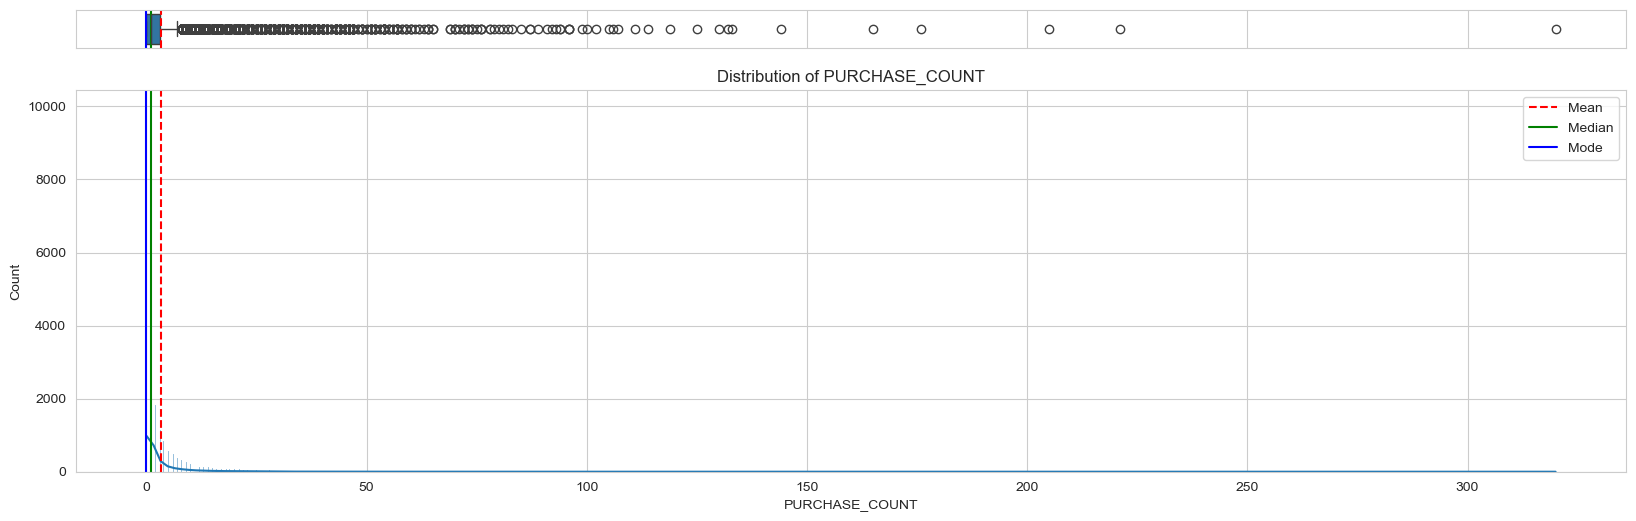

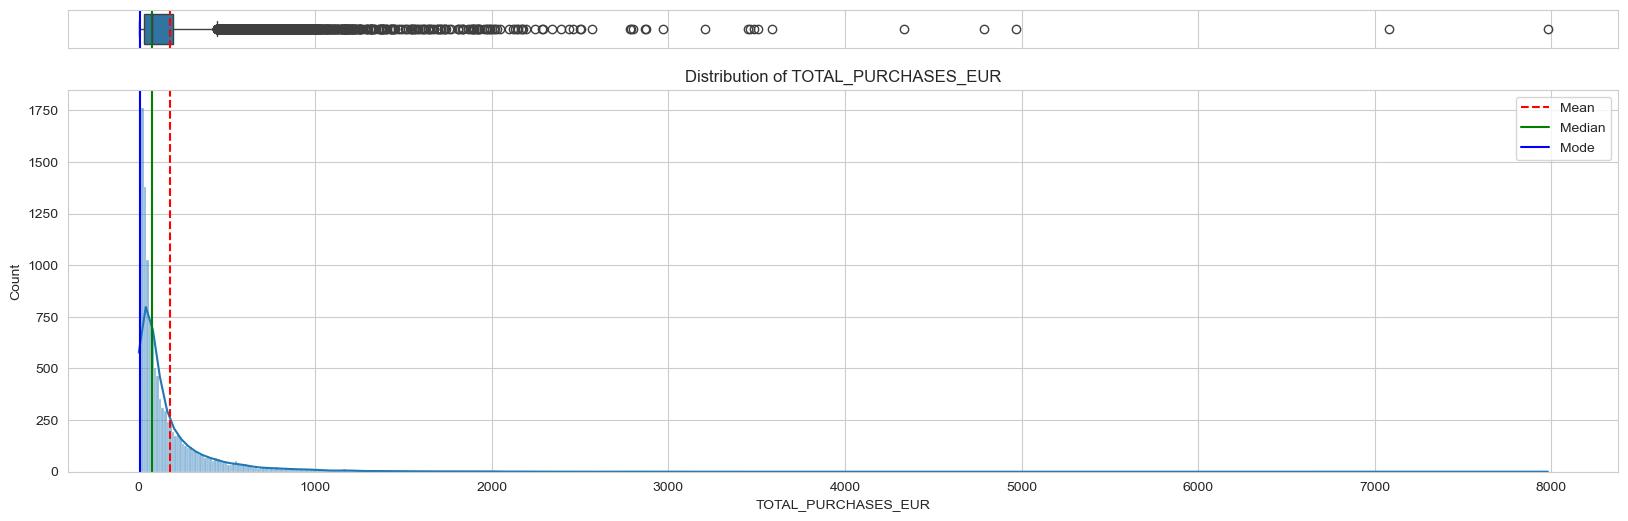

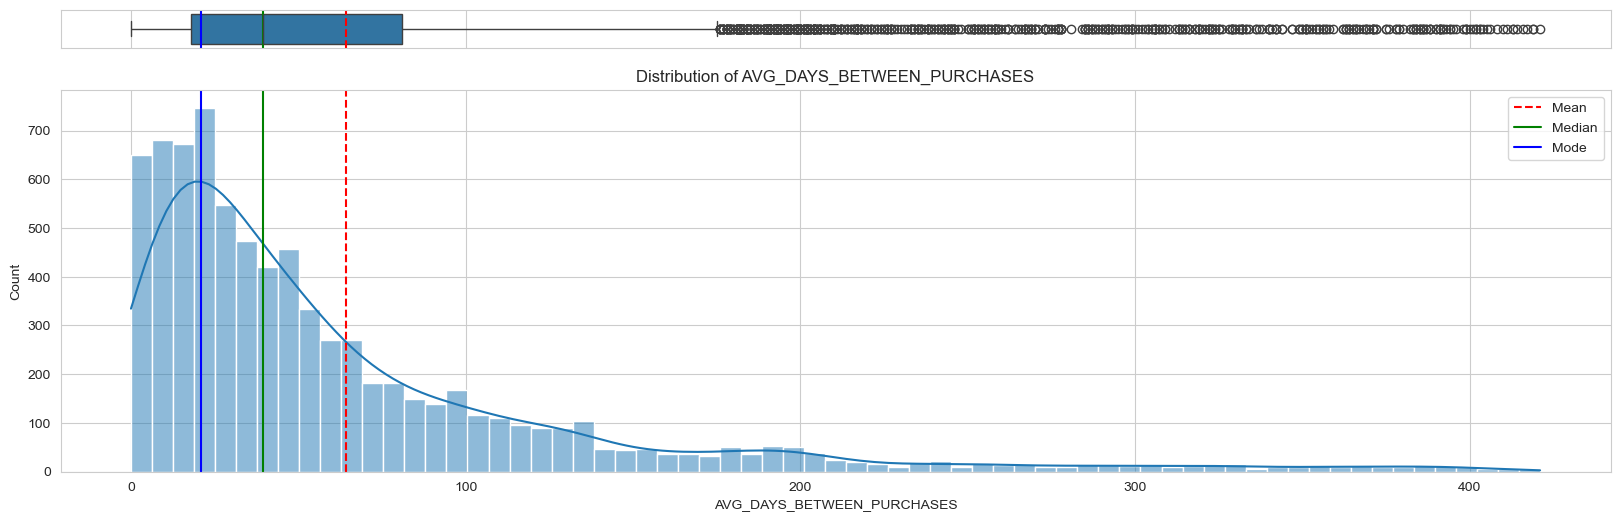

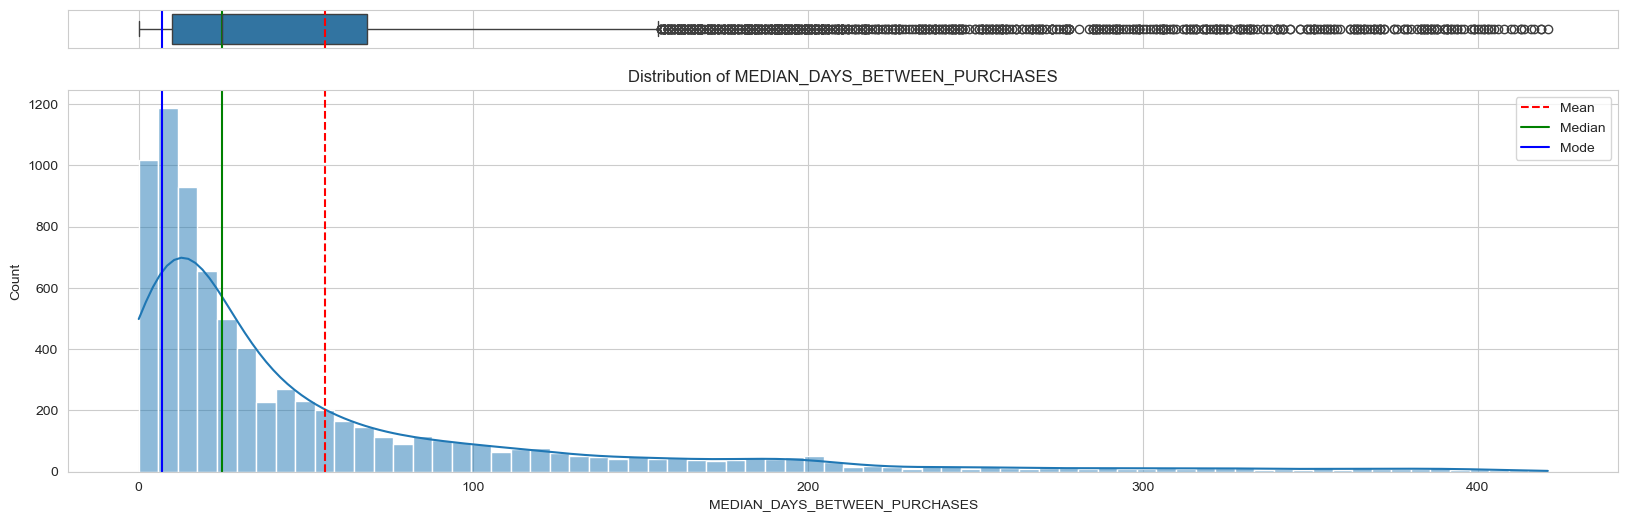

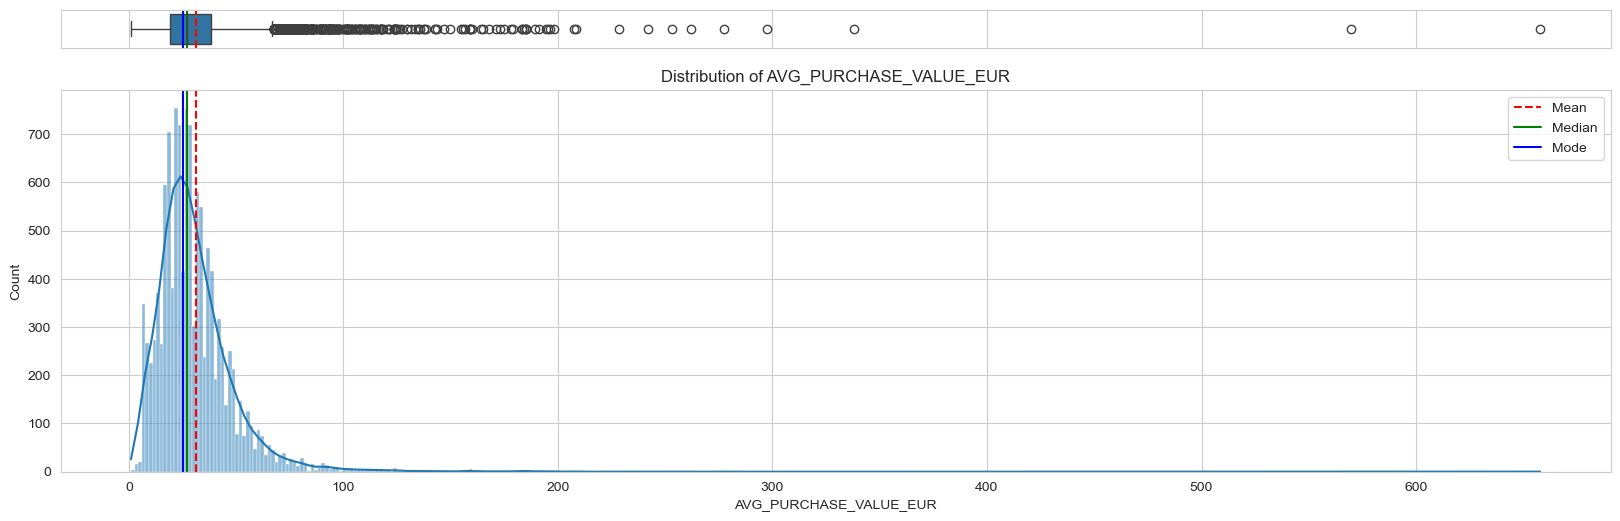

In [27]:
variables = ['PURCHASE_COUNT', 'TOTAL_PURCHASES_EUR', 'AVG_DAYS_BETWEEN_PURCHASES', 'MEDIAN_DAYS_BETWEEN_PURCHASES', 'AVG_PURCHASE_VALUE_EUR']
for var in variables:
    plot_distribution(df, var)

The first plot visualizes the distribution of the "PURCHASE_COUNT" variable.

1. Box Plot (Top): Shows the spread of purchase counts with a large number of outliers on the higher end.
2. Histogram (Bottom): Illustrates the frequency distribution of purchase counts, which is highly skewed to the right.
3. Mean, Median, Mode: The red dashed line represents the mean, the green line indicates the median, and the blue line shows the mode. All these measures are clustered near the lower purchase counts, reflecting the right-skewed nature of the data where most users have low purchase counts, but there are a few users with significantly higher counts.

The second plot visualizes the distribution of the "TOTAL_PURCHASES_EUR" variable.

1. Box Plot (Top): Shows the spread of total purchase amounts in euros, with many outliers on the higher end.
2. Histogram (Bottom): Displays the frequency distribution of total purchase amounts, which is highly skewed to the right.
3. Mean, Median, Mode: The red dashed line represents the mean, the green line indicates the median, and the blue line shows the mode. All these measures are clustered towards the lower end of the distribution, reflecting the right-skewed nature where most users have low total purchase amounts, but there are a few users with significantly higher amounts.

The third visualizes the distribution of the "AVG_DAYS_BETWEEN_PURCHASES" variable.

1. Box Plot (Top): Shows the spread of the average number of days between purchases, with many outliers on the higher end.
2. Histogram (Bottom): Displays the frequency distribution of the average days between purchases, which is right-skewed.
3. Mean, Median, Mode: The red dashed line represents the mean, the green line indicates the median, and the blue line shows the mode. The measures are close but distinct, indicating that most users have relatively short intervals between purchases, with fewer users having longer intervals. The mode is the shortest interval, reflecting the peak in the histogram.

The fourth visualizes the distribution of the "MEDIAN_DAYS_BETWEEN_PURCHASES" variable.

1. Box Plot (Top): Shows the spread of the median number of days between purchases, with many outliers on the higher end.
2. Histogram (Bottom): Displays the frequency distribution of the median days between purchases, which is right-skewed.
3. Mean, Median, Mode: The red dashed line represents the mean, the green line indicates the median, and the blue line shows the mode. The measures are close but distinct, with the mode at the shortest interval, reflecting the peak in the histogram. Most users have shorter intervals between purchases, with fewer users having longer intervals. The histogram shows a significant number of users having median days between purchases clustered around a low number, tapering off as the intervals increase.

The fifth visualizes the distribution of the "AVG_PURCHASE_VALUE_EUR" variable.

1. Box Plot (Top): Shows the spread of average purchase values in euros, with several outliers on the higher end.
2. Histogram (Bottom): Displays the frequency distribution of average purchase values, which is right-skewed.
3. Mean, Median, Mode: The red dashed line represents the mean, the green line indicates the median, and the blue line shows the mode. These measures are clustered closely, indicating that most average purchase values are relatively low. The mode is the highest peak in the histogram, reflecting the most common average purchase value, while the mean is slightly higher than the median, showing the influence of higher values in the distribution. The histogram shows a gradual decline in frequency as the average purchase value increases.

<Axes: xlabel='REGISTRATION_COUNTRY'>

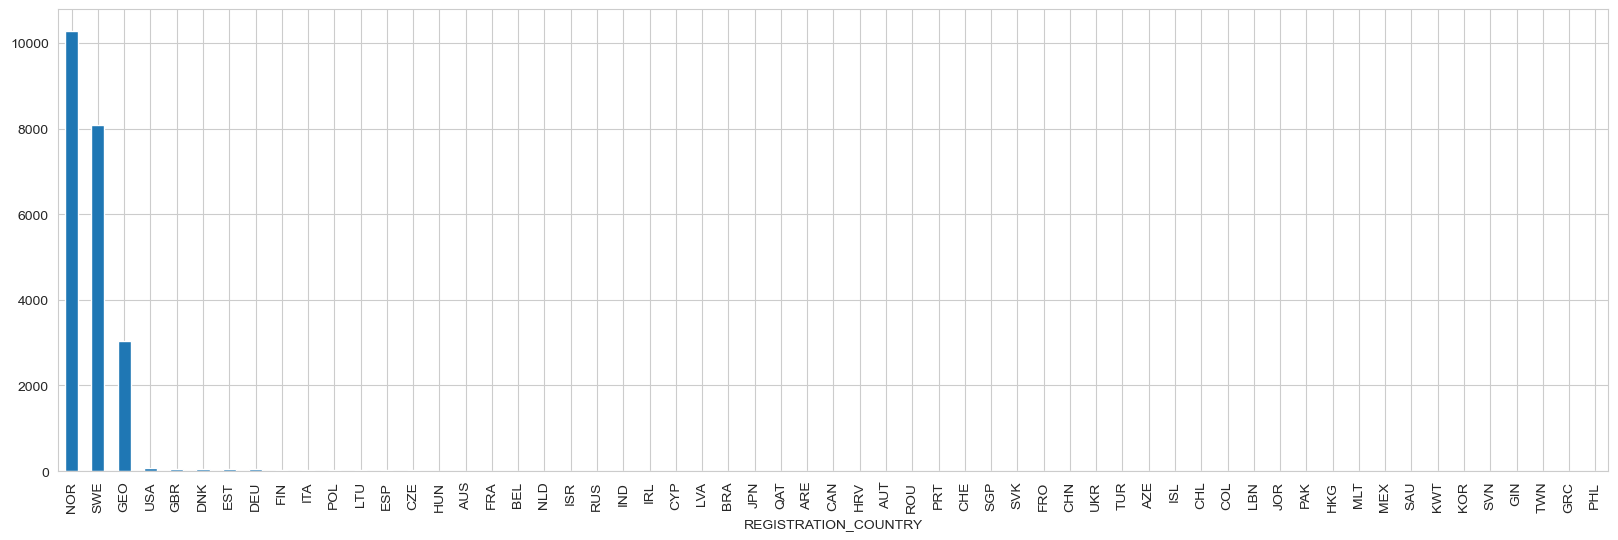

In [28]:
df_final.groupby("REGISTRATION_COUNTRY").size().sort_values(ascending=False).plot(kind="bar", figsize=(20, 6))

1. Data Grouping: The data is grouped by "REGISTRATION_COUNTRY" and sorted in descending order of the count of registrations.
2. Visualization: The bar plot shows the number of registrations for each country.
3. Insights: Norway (NOR) has the highest number of registrations, followed by Sweden (SWE) and Georgia (GEO). The United States (USA) also has a significant number of registrations. Other countries have considerably fewer registrations, as indicated by the shorter bars. This plot highlights the concentration of user registrations in specific countries.

<Axes: xlabel='REGISTRATION_COUNTRY'>

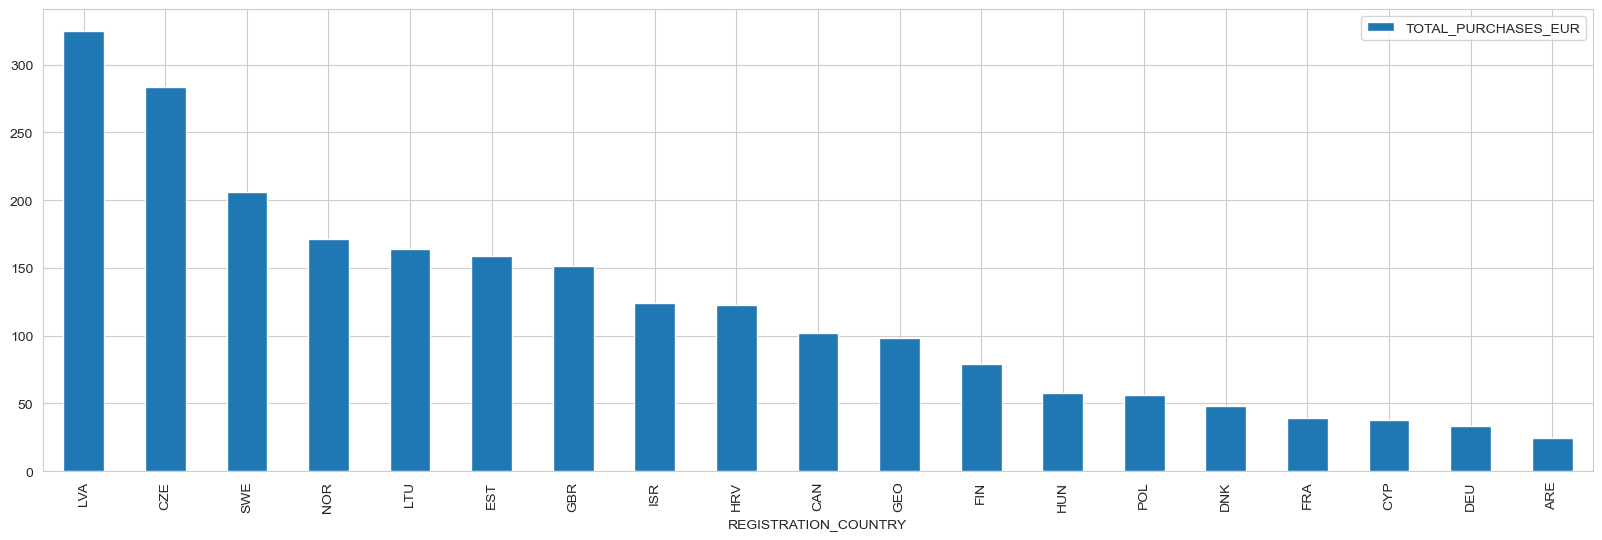

In [29]:
df_final.groupby("REGISTRATION_COUNTRY").agg({"TOTAL_PURCHASES_EUR":"mean"}).dropna().sort_values(by=["TOTAL_PURCHASES_EUR"], ascending=False).plot(kind="bar", figsize=(20, 6))

1. Data Grouping: The data is grouped by "REGISTRATION_COUNTRY" and aggregated to compute the mean of "TOTAL_PURCHASES_EUR". Missing values are dropped.
2. Visualization: The bar plot shows the average total purchases for each country, sorted in descending order.
3. Insights: Latvia (LVA) has the highest average total purchases, followed by the Czech Republic (CZE) and Sweden (SWE). Norway (NOR) also shows a significant average. The plot highlights variations in average spending across different countries, indicating where users tend to spend more on average.

<Axes: xlabel='PREFERRED_DEVICE'>

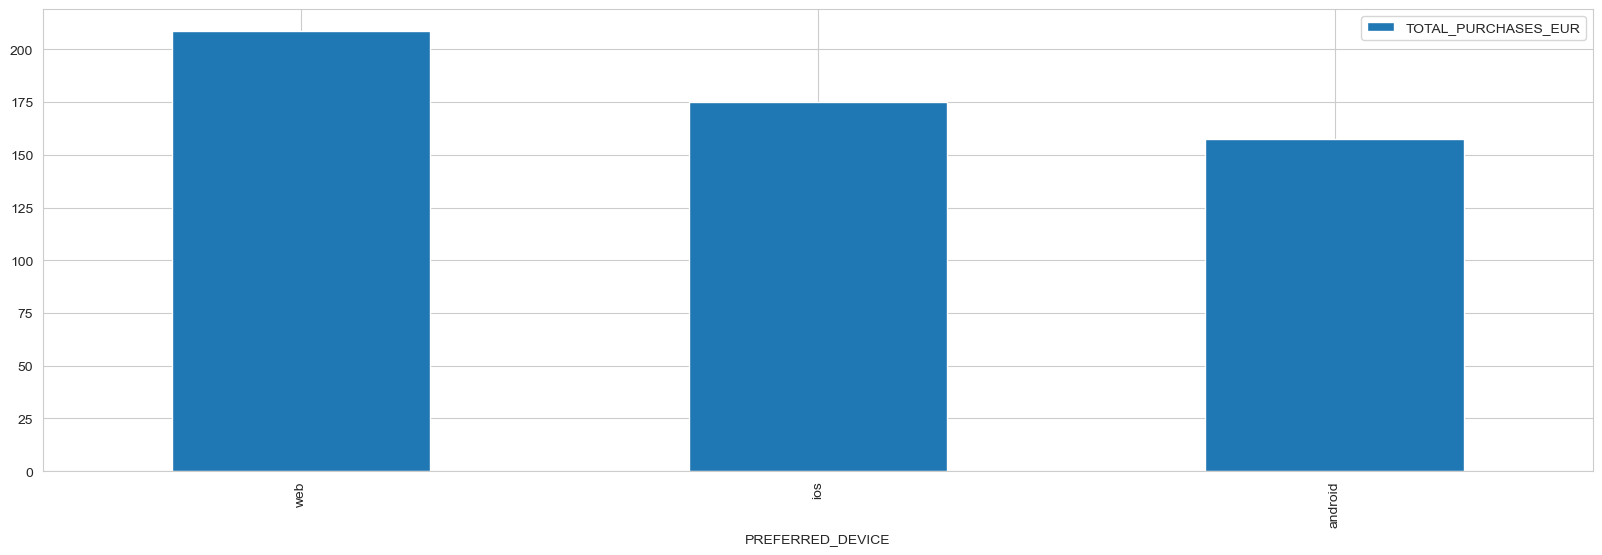

In [30]:
df_final.groupby("PREFERRED_DEVICE").agg({"TOTAL_PURCHASES_EUR":"mean"}).dropna().sort_values(by=["TOTAL_PURCHASES_EUR"], ascending=False).plot(kind="bar", figsize=(20, 6))

<Axes: xlabel='MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE'>

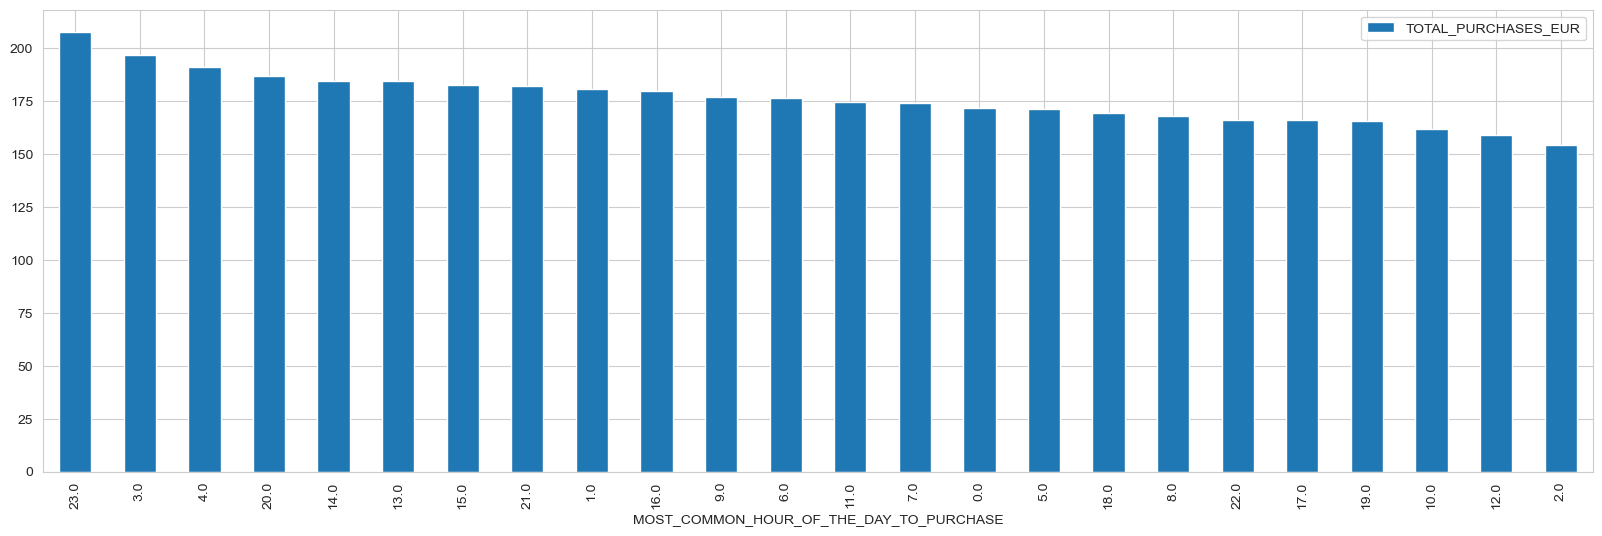

In [31]:
df_final.groupby("MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE").agg({"TOTAL_PURCHASES_EUR":"mean"}).dropna().sort_values(by=["TOTAL_PURCHASES_EUR"], ascending=False).plot(kind="bar", figsize=(20, 6))

In [32]:
df.PREFERRED_RESTAURANT_TYPES.value_counts()

PREFERRED_RESTAURANT_TYPES
[\n  "american"\n]                                                                 658
[\n  "japanese"\n]                                                                 367
[\n  "italian"\n]                                                                  345
[\n  "mexican"\n]                                                                  175
[\n  "american",\n  "italian"\n]                                                   131
                                                                                  ... 
[\n  "mexican",\n  "american",\n  "indian"\n]                                        1
[\n  "american",\n  "japanese",\n  "vietnamese"\n]                                   1
[\n  "spanish"\n]                                                                    1
[\n  "american",\n  "middle eastern",\n  "greek",\n  "italian",\n  "mexican"\n]      1
[\n  "italian",\n  "hawaiian",\n  "mexican",\n  "vietnamese"\n]                      1
Name: count, Len

In [33]:
def transform_string(s):
    if pd.isna(s):
        return s
    s = s.replace('[\n  "', '').replace('"\n]', '').replace('",\n  "', ',')
    return s

df_final['PREFERRED_RESTAURANT_TYPES'] = df_final['PREFERRED_RESTAURANT_TYPES'].apply(transform_string)

In [34]:
df_final['PREFERRED_RESTAURANT_TYPES'].value_counts()

PREFERRED_RESTAURANT_TYPES
american                                         658
japanese                                         367
italian                                          345
mexican                                          175
american,italian                                 131
                                                ... 
mexican,american,indian                            1
american,japanese,vietnamese                       1
spanish                                            1
american,middle eastern,greek,italian,mexican      1
italian,hawaiian,mexican,vietnamese                1
Name: count, Length: 247, dtype: int64

The code block processes the "PREFERRED_RESTAURANT_TYPES" column to clean up the string format and then applies the transformation.

1. Value Counts: df.PREFERRED_RESTAURANT_TYPES.value_counts() is used to count the occurrences of each unique combination of preferred restaurant types.
2. Function Definition: The transform_string function cleans the strings by removing newline characters (\n) and replacing them with commas.
3. Apply Transformation: The transform_string function is applied to the "PREFERRED_RESTAURANT_TYPES" column in the DataFrame to standardize the format of the strings.
This transformation ensures that the restaurant types are properly formatted and easier to read and analyze.

In [35]:
# Split the restaurant types into lists of words
df_final['restaurant_list'] = df_final['PREFERRED_RESTAURANT_TYPES'].fillna('').apply(lambda x: x.split(',') if x else [])

# Train Word2Vec model
model = Word2Vec(sentences=df_final['restaurant_list'], vector_size=16, window=5, min_count=1, sg=1, seed=42)

# Function to get the embeddings for a list of words
def get_embedding(words, model):
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Get embeddings for each row
df_final['embedding'] = df_final['restaurant_list'].apply(lambda x: get_embedding(x, model))

# Split the embeddings into separate columns
embedding_df = pd.DataFrame(df_final['embedding'].tolist(), index=df.index)
embedding_df.columns = [f'preferred_restaurant_dim_{i+1}' for i in range(embedding_df.shape[1])]

embedding_df["PREFERRED_RESTAURANT_TYPES"] = df_final['PREFERRED_RESTAURANT_TYPES']

This code block processes the "PREFERRED_RESTAURANT_TYPES" column to generate word embeddings using the Word2Vec model. Here's a step-by-step breakdown:

1. Split the Restaurant Types: The "PREFERRED_RESTAURANT_TYPES" column is split into lists of words, stored in a new column "restaurant_list".
2. Train Word2Vec Model: A Word2Vec model is trained on the "restaurant_list" with specific parameters (vector size of 16, window of 5, minimum count of 1, skip-gram model).
3. Define Embedding Function: The get_embedding function computes the mean embedding for a list of words if the words are in the model's vocabulary. If no embeddings are found, it returns a zero vector of the model's vector size.
4. Compute Embeddings for Each Row: The get_embedding function is applied to the "restaurant_list" column to generate embeddings for each row, stored in a new column "embedding".
5. Split Embeddings into Separate Columns: The embeddings are split into separate columns in a new DataFrame embedding_df, with columns named "preferred_restaurant_dim_{i+1}".
6. Update Original DataFrame: The original "PREFERRED_RESTAURANT_TYPES" column is retained for reference.


In [37]:
df_final["LEN_PREFERRED_RESTAURANT_TYPES"] = df_final["restaurant_list"].apply(lambda x: len(x))
df_final = df_final.drop(columns=["embedding", "restaurant_list", "PURCHASE_COUNT_BY_STORE_TYPE", "PREFERRED_RESTAURANT_TYPES"])

<Axes: ylabel='Frequency'>

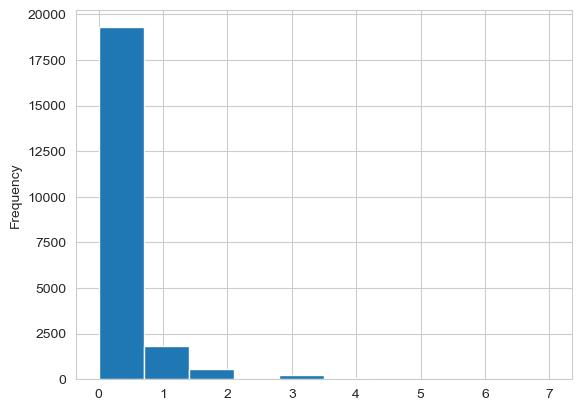

In [38]:
df_final["LEN_PREFERRED_RESTAURANT_TYPES"].plot(kind="hist")

In [39]:
df_final

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,General merchandise,Grocery,Pet supplies,Restaurant,Retail store,LEN_PREFERRED_RESTAURANT_TYPES
0,2020-09-01,SWE,0,NaN,NaN,NaT,NaT,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,2020-09-01,NOR,1,1.0,0.0,2021-09-02,2021-09-02,2,0.0,1.0,0.0,0.0,0.0,38.456,1.0,38.532,38.608,38.456,android,0.0,0.0,1.0,False,23.0,2.0,NaN,NaN,6.853,0,0,0,1,0,0
2,2020-09-01,SWE,19,19.0,0.0,2020-12-10,2021-05-25,3,0.0,4.0,1.0,14.0,0.0,631.488,9.0,20.280,43.688,33.396,android,0.0,19.0,0.0,True,21.0,2.0,9.0,3.0,6.559,1,9,0,9,0,0
3,2020-09-01,NOR,0,NaN,NaN,NaT,NaT,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,2020-09-01,GEO,0,NaN,NaN,NaT,NaT,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21978,2020-09-30,GEO,1,1.0,0.0,2021-01-23,2021-01-23,21979,0.0,0.0,1.0,0.0,0.0,26.312,1.0,26.364,26.416,26.312,android,0.0,0.0,1.0,False,12.0,2.0,NaN,NaN,1.383,0,0,0,1,0,0
21979,2020-09-30,GEO,0,NaN,NaN,NaT,NaT,21980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
21980,2020-09-30,SWE,0,NaN,NaN,NaT,NaT,21981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
21981,2020-09-30,SWE,0,NaN,NaN,NaT,NaT,21982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0


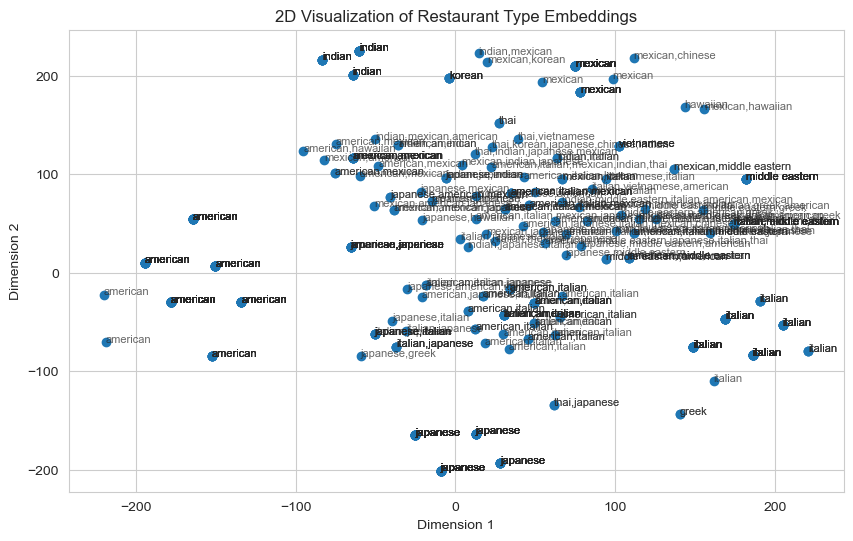

In [40]:
plot_df = embedding_df
plot_df = plot_df.dropna()

# Select a maximum of 250 random points for plotting
if len(plot_df) > 250:
    plot_df = plot_df.sample(n=500, random_state=42)

# Visualize the embeddings using t-SNE
embeddings = plot_df[[f'preferred_restaurant_dim_{i+1}' for i in range(10)]].values
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate the points with their corresponding restaurant types
for i, txt in enumerate(plot_df['PREFERRED_RESTAURANT_TYPES']):
    plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title('2D Visualization of Restaurant Type Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

1. Prepare Data for Plotting:

A random sample of 250 rows is selected to keep the plot manageable.

2. t-SNE Visualization:

t-SNE (t-Distributed Stochastic Neighbor Embedding) is used to reduce the dimensionality of the embeddings to 2 components.
The reduced embeddings are stored in embeddings_2d.


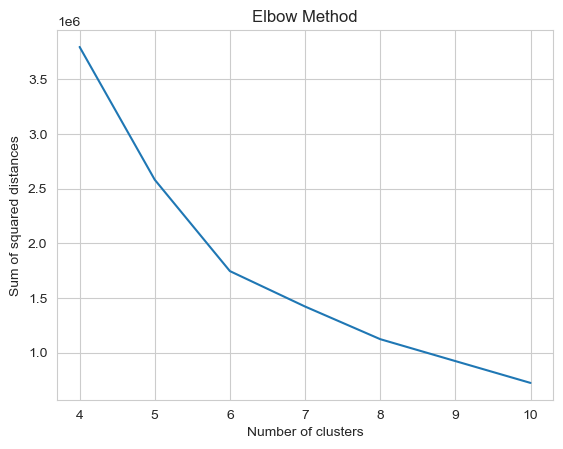

In [41]:
k_range = range(4, 11)

# Initialize variables to store the sum of squared distances and silhouette scores
sse = []
silhouette_scores = []

embeddings = embedding_df[[f'preferred_restaurant_dim_{i+1}' for i in range(10)]].values
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


# Iterate over different values of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_2d)
    sse.append(kmeans.inertia_)
    
    if k > 1:
        silhouette_scores.append(silhouette_score(embeddings_2d, kmeans.labels_))

# Plot the elbow curve
plt.plot(k_range, sse)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

Optimal number of clusters: 6
Cluster labels:
[0 0 0 ... 0 0 0]
Cluster centroids:
[[ -6.660494  -3.313521]
 [111.85853  -31.863152]
 [ 48.727955  80.64242 ]
 [-19.83755  100.05416 ]
 [ 61.30728  -76.98564 ]
 [ 91.12969   26.484758]]


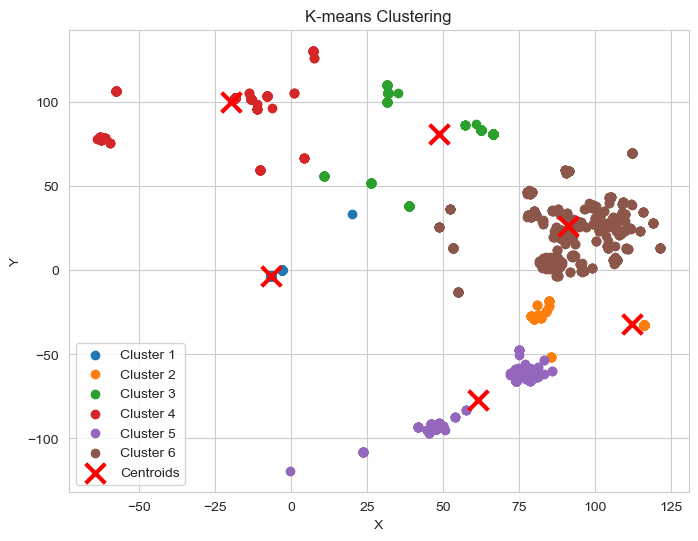

In [42]:
# Determine the optimal number of clusters based on the elbow point
optimal_k = 6

# Perform k-means clustering with the optimal number of clusters
if optimal_k:
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(embeddings_2d)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    print(f"Optimal number of clusters: {optimal_k}")
    print("Cluster labels:")
    print(labels)
    print("Cluster centroids:")
    print(centroids)
    
    # Visualize the clusters
    plt.figure(figsize=(8, 6))
    for i in range(optimal_k):
        plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], label=f'Cluster {i+1}')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', label='Centroids')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('K-means Clustering')
    plt.legend()
    plt.show()

In [43]:
df_final["RESTAURANT_TYPE_CLUSTER"] = labels

<Axes: xlabel='RESTAURANT_TYPE_CLUSTER'>

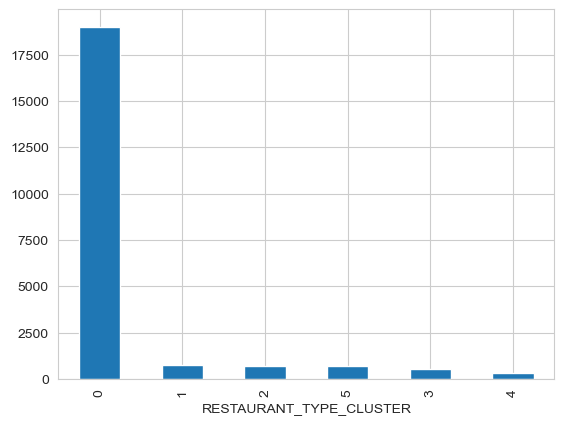

In [44]:
df_final["RESTAURANT_TYPE_CLUSTER"].value_counts().plot(kind="bar")

<Axes: xlabel='RESTAURANT_TYPE_CLUSTER'>

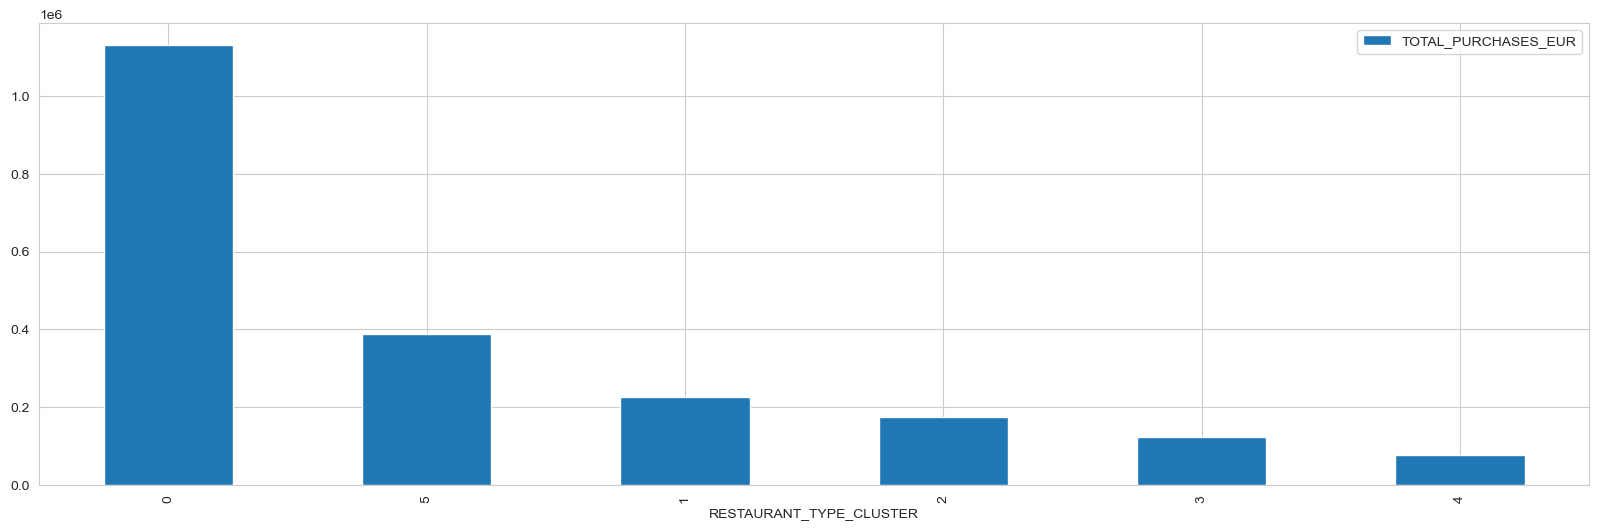

In [45]:
df_final.groupby("RESTAURANT_TYPE_CLUSTER").agg({"TOTAL_PURCHASES_EUR":"sum"}).dropna().sort_values(by=["TOTAL_PURCHASES_EUR"], ascending=False).plot(kind="bar", figsize=(20, 6))

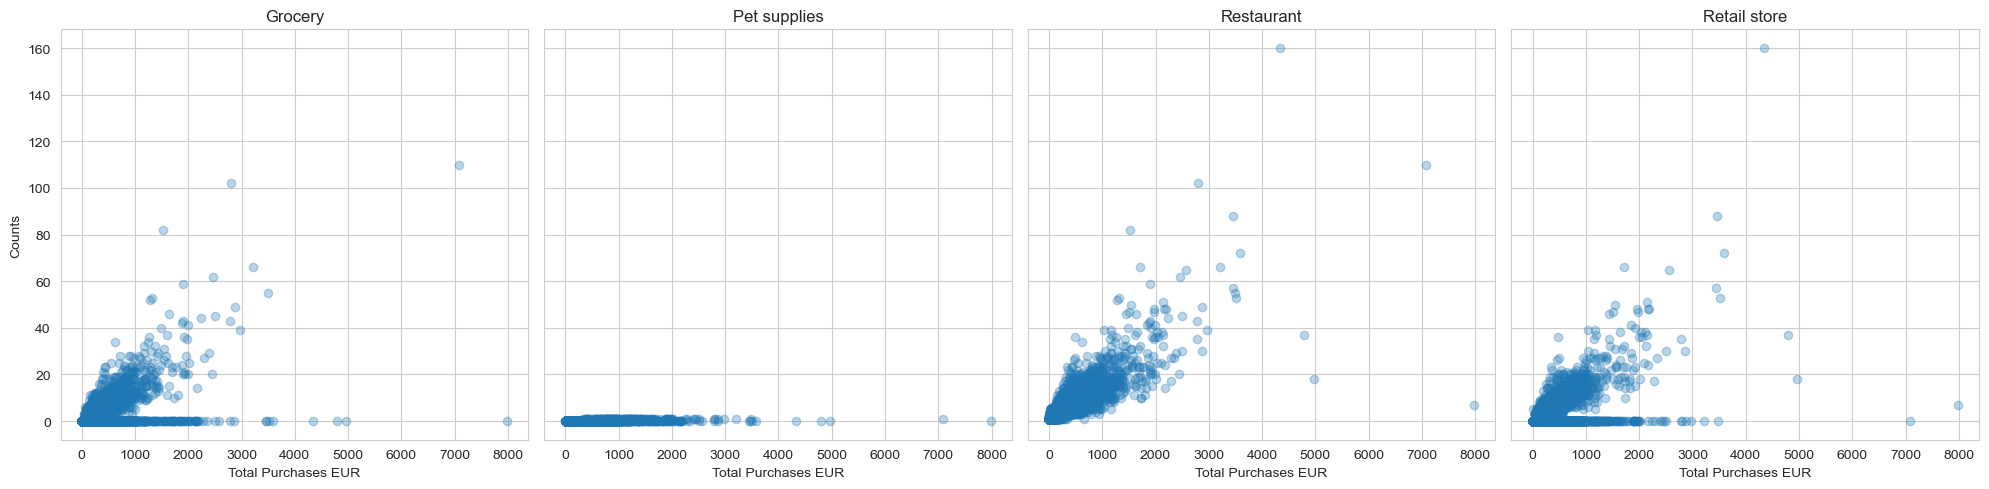

In [46]:
columns = ['Grocery', 'Pet supplies', 'Restaurant', 'Retail store']

fig, axs = plt.subplots(1, len(columns), figsize=(20, 5), sharey=True)

for i, column in enumerate(columns):

    axs[i].scatter(df_final['TOTAL_PURCHASES_EUR'], df_final[column], alpha=0.3)
    axs[i].set_title(column)
    axs[i].set_xlabel('Total Purchases EUR')
    if i == 0:
        axs[i].set_ylabel('Counts')

# Display the plot
plt.tight_layout()
plt.show()

The plots show the distribution and relationship of total purchases in euros with counts for each store type, indicating higher concentration at lower purchase amounts.

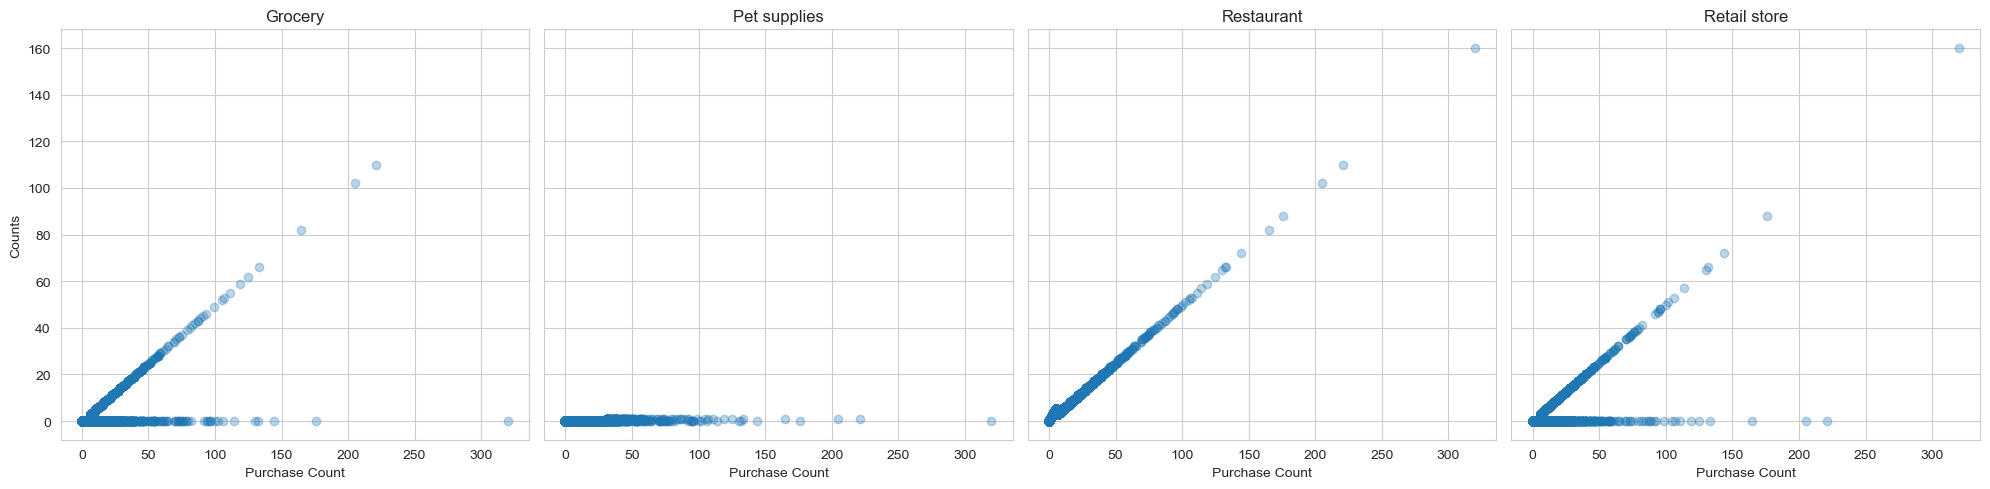

In [47]:
columns = ['Grocery', 'Pet supplies', 'Restaurant', 'Retail store']

# Initialize the plot
fig, axs = plt.subplots(1, len(columns), figsize=(20, 5), sharey=True)

# Plot each scatter plot
for i, column in enumerate(columns):
    axs[i].scatter(df_final['PURCHASE_COUNT'], df_final[column], alpha=0.3)
    axs[i].set_title(column)
    axs[i].set_xlabel('Purchase Count')
    if i == 0:
        axs[i].set_ylabel('Counts')

# Display the plot
plt.tight_layout()
plt.show()

These plots illustrate the relationship between the purchase count and the frequency of purchases across different store types, highlighting the distribution and any potential patterns.

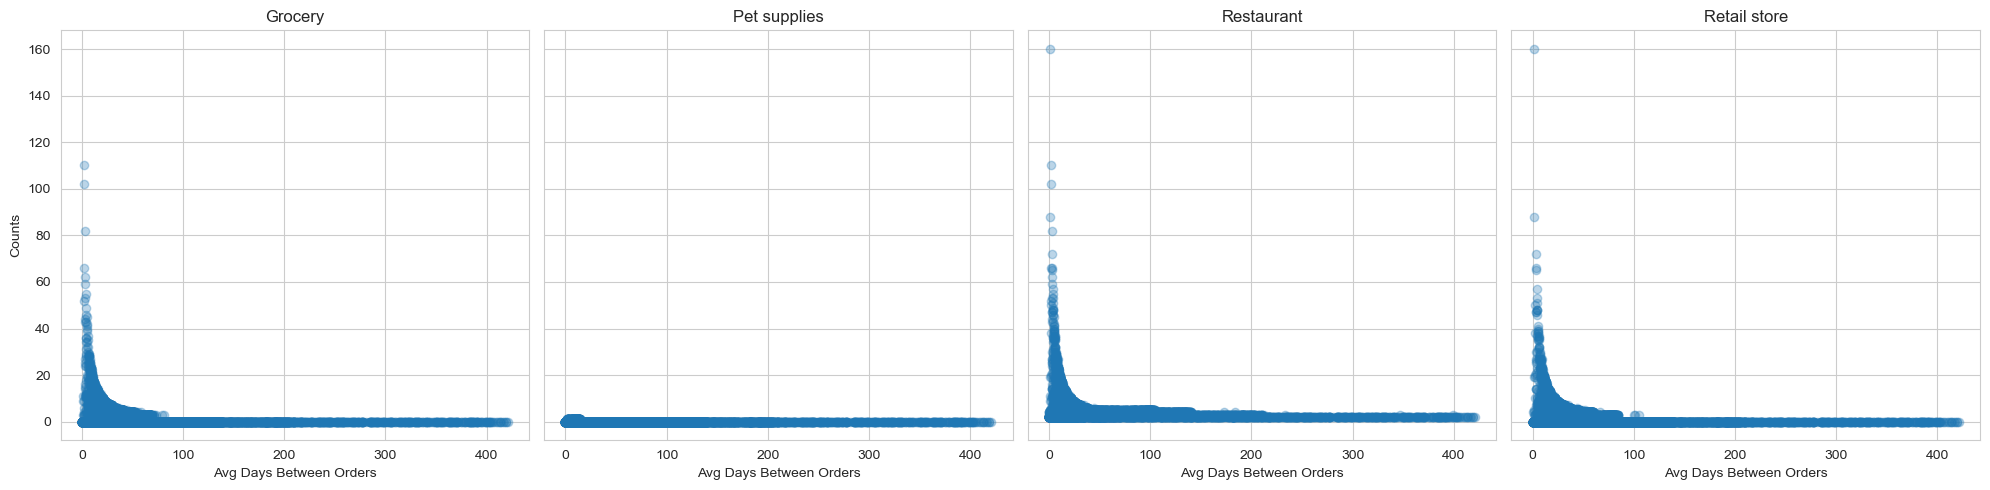

In [48]:
columns = ['Grocery', 'Pet supplies', 'Restaurant', 'Retail store']

# Initialize the plot
fig, axs = plt.subplots(1, len(columns), figsize=(20, 5), sharey=True)

# Plot each scatter plot
for i, column in enumerate(columns):
    axs[i].scatter(df_final['AVG_DAYS_BETWEEN_PURCHASES'], df_final[column], alpha=0.3)
    axs[i].set_title(column)
    axs[i].set_xlabel('Avg Days Between Orders')
    if i == 0:
        axs[i].set_ylabel('Counts')

# Display the plot
plt.tight_layout()
plt.show()

There is a high concentration of data points at lower values of average days between orders, indicating that users tend to make frequent purchases, with fewer users having longer intervals between purchases.

## Approach #1

Using basic RFM score for segmentation

In [142]:
rfm_df = df[df['LAST_PURCHASE_DAY'].notnull()].copy()

In [53]:
rfm_df.shape

(12009, 30)

In [54]:
rfm_df['RECENCY'] = (MAX_DATE - rfm_df['LAST_PURCHASE_DAY']).dt.days
rfm_df['FREQUENCY'] = rfm_df['PURCHASE_COUNT']
rfm_df['MONETARY'] = rfm_df['TOTAL_PURCHASES_EUR']

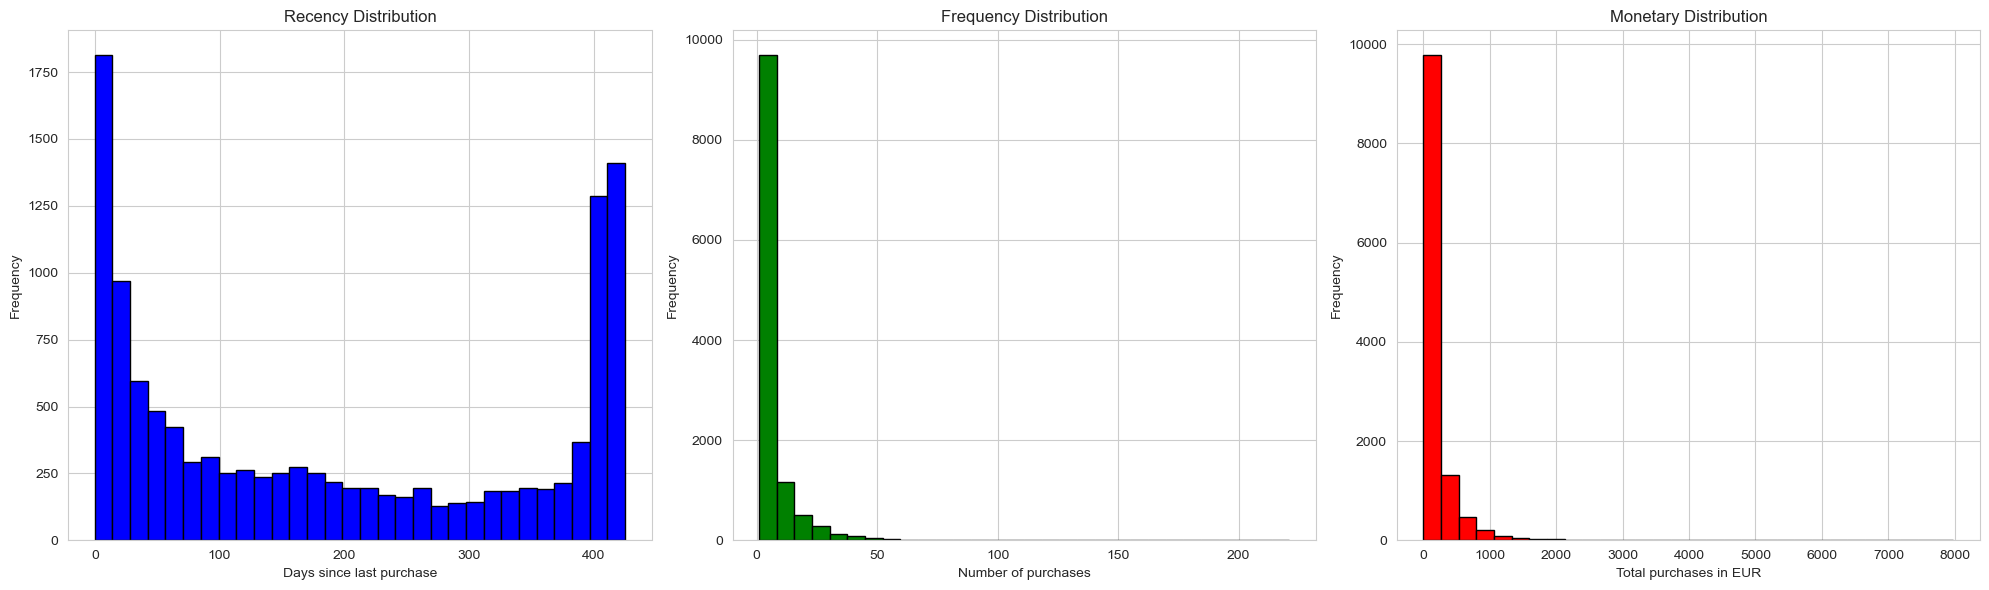

In [55]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.hist(rfm_df['RECENCY'], bins=30, color='blue', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(rfm_df['FREQUENCY'], bins=30, color='green', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Number of purchases')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(rfm_df['MONETARY'], bins=30, color='red', edgecolor='black')
plt.title('Monetary Distribution')
plt.xlabel('Total purchases in EUR')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [56]:
rfm_df['FREQUENCY'].describe()

count    12009.000000
mean         6.091431
std         10.382771
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
max        221.000000
Name: FREQUENCY, dtype: float64

In [297]:
rfm_df['RECENCY'].describe()

count    12009.000000
mean       194.564577
std        160.203844
min          0.000000
25%         34.000000
50%        162.000000
75%        385.000000
max        425.000000
Name: RECENCY, dtype: float64

25th percentile same as the 50th percentile - we need to define frequency bins

In [57]:
frequency_bins = [0, 1, 2, 5, rfm_df['FREQUENCY'].max()]
frequency_labels = ['1', '2', '3', '4']
rfm_df['F_SCORE'] = pd.cut(rfm_df['FREQUENCY'], bins=frequency_bins, labels=frequency_labels, include_lowest=True)

In [58]:
rfm_df['R_SCORE'] = pd.qcut(rfm_df['RECENCY'], 4, labels=['1', '2', '3', '4'])
rfm_df['M_SCORE'] = pd.qcut(rfm_df['MONETARY'].rank(method='first'), 4, labels=['1', '2', '3', '4'])

In [59]:
def define_segment(row):
    if row['R_SCORE'] == '1' and row['F_SCORE'] == '4' and row['M_SCORE'] == '4':
        return 'Champions'
    elif row['R_SCORE'] == '1' and row['F_SCORE'] in ['3', '4']:
        return 'Loyal Customers'
    elif row['R_SCORE'] in ['2', '3'] and row['F_SCORE'] in ['3', '4']:
        return 'Potential Loyalists'
    elif row['R_SCORE'] == '1' and row['F_SCORE'] in ['1', '2']:
        return 'New Customers'
    elif row['R_SCORE'] in ['2', '3'] and row['F_SCORE'] == '2':
        return 'Promising'
    elif row['R_SCORE'] in ['2', '3'] and row['F_SCORE'] == '1':
        return 'About to Sleep'
    elif row['R_SCORE'] == '4' and row['F_SCORE'] in ['3', '4']:
        return 'At Risk'
    elif row['R_SCORE'] == '4' and row['F_SCORE'] in ['1', '2']:
        return 'Hibernating'
    elif row['R_SCORE'] == '3' and row['F_SCORE'] == '3':
        return 'Need Attention'
    else:
        return 'Other'

rfm_df['RFM_SEGMENT'] = rfm_df.apply(define_segment, axis=1)

In [60]:
rfm_df['RFM_SEGMENT'].value_counts()

RFM_SEGMENT
Potential Loyalists    3301
Hibernating            2867
Champions              1618
About to Sleep         1370
Promising              1295
Loyal Customers         974
New Customers           460
At Risk                 124
Name: count, dtype: int64

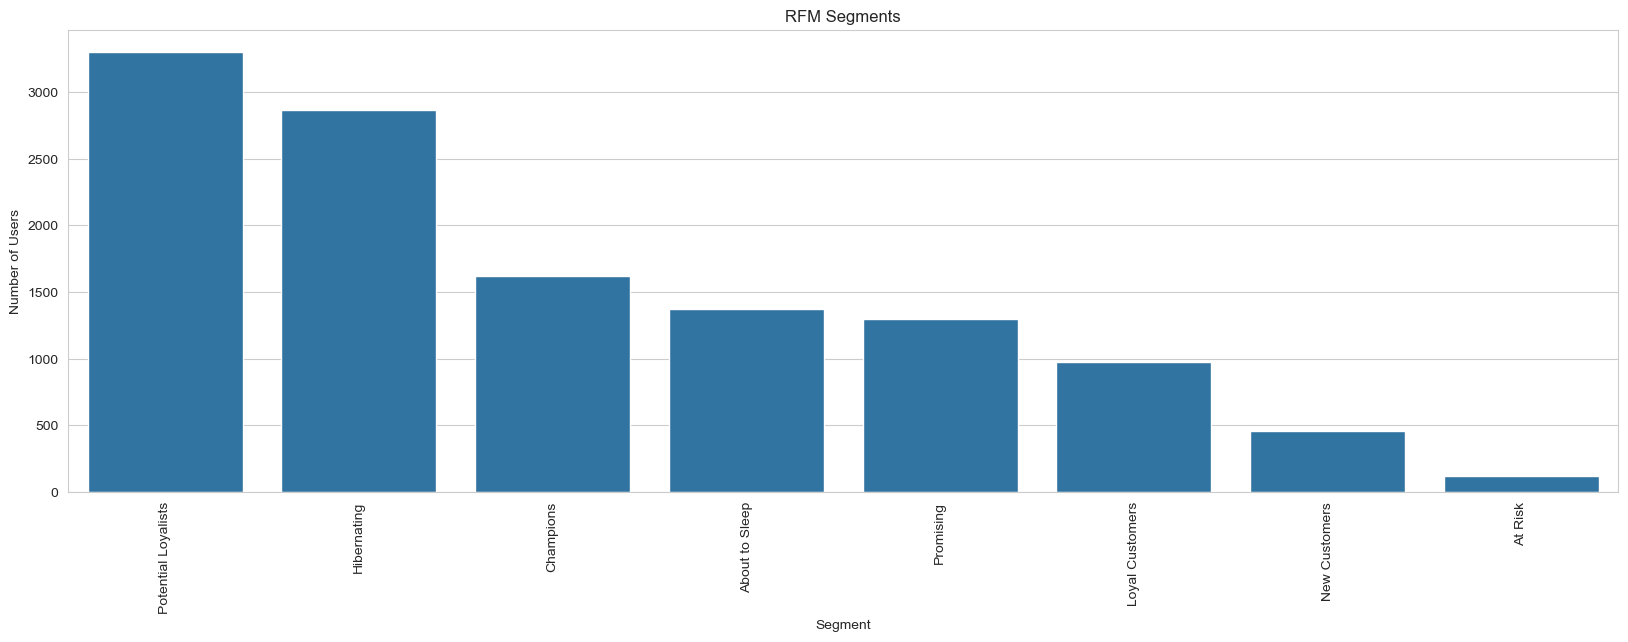

In [61]:
plt.figure(figsize=(20, 6))
sns.countplot(x='RFM_SEGMENT', data=rfm_df, order=rfm_df['RFM_SEGMENT'].value_counts().index)
plt.title('RFM Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=90)
plt.show()

This code block performs RFM (Recency, Frequency, Monetary) analysis and segmentation of customer data.

1. Calculate RFM Metrics:

- Recency: Calculated as the number of days since the last purchase `((max_date - df_final['LAST_PURCHASE_DAY']).dt.days)`.
- Frequency: Total number of purchases `(df_final['PURCHASE_COUNT'])`.
- Monetary: Total amount spent in euros `(df_final['TOTAL_PURCHASES_EUR'])`.

  
2. Plot RFM Distributions:

- Three histograms are created to visualize the distribution of recency, frequency, and monetary values.

3. RFM Descriptive Statistics:

- Descriptive statistics for the RFM metrics are displayed.

4. Define RFM Segments:

- Recency Segments: Defined using quintiles (pd.qcut).
- Frequency Segments: Also defined using quintiles (pd.qcut).
- Monetary Segments: Similarly, defined using quintiles (pd.qcut).

5. Create RFM Segment Labels:

- Combined RFM scores are calculated by concatenating the individual R, F, and M scores.

6. Assign RFM Segments:

- A new column RFM_Segment is created to store the concatenated RFM scores.
- The segments are further categorized into meaningful segments like 'Champions', 'Loyal Customers', etc.

7. Plot RFM Segments:

- A bar plot visualizes the count of customers in each RFM segment.

## Modelling

In [50]:
df_final.shape

(21983, 35)

In [52]:
df_final = df_final[df_final.PURCHASE_COUNT > 0]

In [53]:
df_final[df_final.FIRST_PURCHASE_DAY.isna()]

,REGISTRATION_DATE,REGISTRATION_COUNTRY,PURCHASE_COUNT,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT_TAKEAWAY,FIRST_PURCHASE_DAY,LAST_PURCHASE_DAY,USER_ID,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,TOTAL_PURCHASES_EUR,DISTINCT_PURCHASE_VENUE_COUNT,MIN_PURCHASE_VALUE_EUR,MAX_PURCHASE_VALUE_EUR,AVG_PURCHASE_VALUE_EUR,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,USER_HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,MEDIAN_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS,General merchandise,Grocery,Pet supplies,Restaurant,Retail store,LEN_PREFERRED_RESTAURANT_TYPES,RESTAURANT_TYPE_CLUSTER
151,2020-09-01,SWE,3,3.0,0.0,NaT,2021-08-18,152,1.0,2.0,0.0,0.0,0.0,115.368,2.0,27.378,50.800,38.456,web,0.0,0.0,3.0,False,16.0,4.0,22.0,22.0,6.520,0,0,0,3,0,0,0
193,2020-09-01,NOR,1,1.0,0.0,NaT,2020-09-01,194,0.0,0.0,0.0,1.0,0.0,76.912,1.0,77.064,77.216,76.912,android,0.0,0.0,1.0,False,20.0,7.0,NaN,NaN,10.284,0,0,0,1,0,0,0
400,2020-09-01,SWE,3,3.0,0.0,NaT,2020-10-04,401,0.0,2.0,0.0,1.0,0.0,90.068,3.0,20.280,43.688,30.360,android,0.0,0.0,3.0,False,23.0,2.0,26.0,26.0,8.635,0,0,0,3,0,0,0
552,2020-09-01,SWE,3,3.0,0.0,NaT,2021-04-25,553,0.0,0.0,1.0,2.0,0.0,145.728,3.0,14.196,108.712,48.576,android,0.0,0.0,3.0,True,4.0,5.0,0.0,0.0,0.041,0,0,0,3,0,0,0
555,2020-09-01,NOR,2,2.0,0.0,NaT,2021-08-28,556,0.0,0.0,2.0,0.0,0.0,55.660,1.0,23.322,32.512,27.324,web,0.0,2.0,0.0,True,18.0,7.0,59.0,59.0,0.536,0,0,0,2,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21094,2020-09-29,SWE,3,3.0,0.0,NaT,2021-07-23,21095,0.0,1.0,0.0,2.0,0.0,122.452,1.0,34.476,44.704,40.480,web,0.0,3.0,0.0,True,3.0,1.0,26.0,26.0,7.601,0,0,0,3,0,0,0
21214,2020-09-29,SWE,13,12.0,1.0,NaT,2021-10-20,21215,0.0,4.0,0.0,9.0,0.0,511.060,13.0,16.224,71.120,39.468,web,5.0,8.0,0.0,True,8.0,6.0,33.0,12.0,1.287,1,6,0,6,0,1,4
21384,2020-09-29,SWE,1,1.0,0.0,NaT,2020-09-29,21385,0.0,0.0,0.0,1.0,0.0,15.180,1.0,15.210,15.240,15.180,web,1.0,0.0,0.0,False,20.0,1.0,NaN,NaN,1.441,0,0,0,1,0,1,3
21451,2020-09-29,SWE,1,0.0,1.0,NaT,2021-08-10,21452,0.0,0.0,0.0,1.0,0.0,46.552,1.0,46.644,46.736,46.552,web,0.0,0.0,1.0,True,16.0,6.0,NaN,NaN,10.093,0,0,0,1,0,0,0


In [54]:
df_final = df_final.dropna(subset=["FIRST_PURCHASE_DAY"])

In [55]:
churn_threshold = 180

In [56]:
# Create duration column: Time from first purchase to the maximum date or last purchase
df_final['duration'] = (MAX_DATE - df_final['FIRST_PURCHASE_DAY']).dt.days

# Create event_observed column: 1 if the purchase count is more than 0, else 0
df_final['event_observed'] = np.where((MAX_DATE - df_final['LAST_PURCHASE_DAY']).dt.days > churn_threshold, 1, 0)

# Calculate days_since_registration
df_final['days_since_registration'] = (MAX_DATE - df_final['REGISTRATION_DATE']).dt.days

This code block prepares data for churn analysis by creating necessary columns for duration, event observation, and days since registration.

1. Set Churn Threshold:

- `churn_threshold` is set to 180 days. This threshold will be used to determine if a customer has churned based on the time since their last purchase.
  
2. Create Duration Column:

- `df_final['duration']`: Calculates the duration from the first purchase to the maximum date or the last purchase date. This is done by subtracting the 'FIRST_PURCHASE_DAY' from 'MAX_DATE' and converting it to days.

4. Create Event Observed Column:

- `df_final['event_observed']`: Creates a binary column where a value of 1 indicates that the customer has made a purchase within the churn threshold (i.e., they have not churned), and 0 indicates that the customer has churned. This is determined by checking if the number of days since the last purchase exceeds the churn threshold.
Calculate Days Since Registration:

- `df_final['days_since_registration']`: Calculates the total number of days since the customer registered. This is done by subtracting the 'REGISTRATION_DATE' from 'MAX_DATE' and converting it to days.

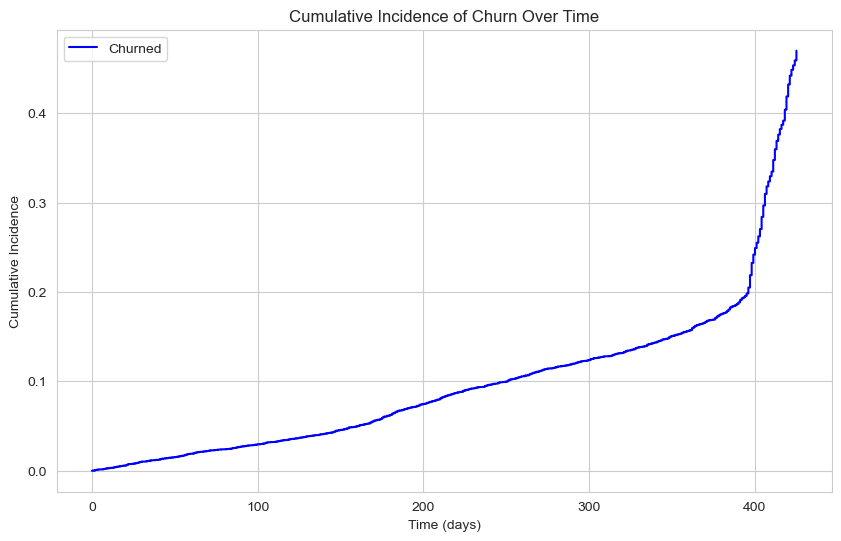

In [57]:
# Create a cumulative incidence plot
plt.figure(figsize=(10, 6))

# Compute the cumulative incidence
cumulative_events = np.cumsum(df_final['event_observed'])
cumulative_times = np.sort(df_final['duration'])

# Normalize by the total number of customers
cumulative_incidence = cumulative_events / len(df_final['event_observed'])

plt.plot(cumulative_times, cumulative_incidence, drawstyle='steps-post', color='blue', label='Churned')

# Add labels and legend
plt.title('Cumulative Incidence of Churn Over Time')
plt.xlabel('Time (days)')
plt.ylabel('Cumulative Incidence')
plt.legend()
plt.grid(True)
plt.show()

This code block creates a cumulative incidence plot to visualize the incidence of customer churn over time.

1. **Compute Cumulative Incidence**:
   - `cumulative_events`: Calculates the cumulative sum of the 'event_observed' column, which tracks the occurrence of churn events.
   - `cumulative_times`: Sorts the 'duration' column in ascending order to get the times at which events are observed.

2. **Normalize by Total Number of Customers**:
   - `cumulative_incidence`: Normalizes the cumulative events by dividing by the total number of customers (`len(df_final['event_observed'])`).

3. **Show the Plot**:
   - The plot is displayed using `plt.show`.

This plot helps in understanding how the incidence of customer churn accumulates over time. The increasing trend in the plot indicates that the longer the customers stay, the more likely they are to churn, especially after certain periods. This visualization is crucial for identifying critical time frames where churn rates spike, allowing for targeted interventions to retain customers.

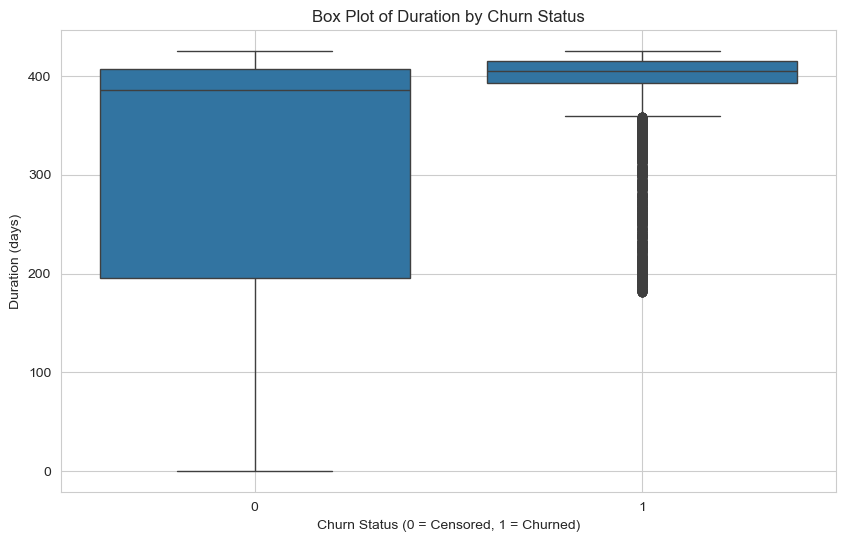

In [58]:
# Create a box plot of duration by event status
plt.figure(figsize=(10, 6))
sns.boxplot(x='event_observed', y='duration', data=df_final)
plt.title('Box Plot of Duration by Churn Status')
plt.xlabel('Churn Status (0 = Censored, 1 = Churned)')
plt.ylabel('Duration (days)')
plt.grid(True)
plt.show()

Observations:

- The box plot shows the distribution of durations for customers who have churned (event_observed = 1) versus those who have not churned (event_observed = 0).
- For churned customers, the duration distribution has a wider range with more outliers, indicating variability in the duration before churn.
- For non-churned customers, the duration distribution is more consistent and generally longer, as expected.

In [65]:
df_final = df_final.dropna(subset=["LAST_PURCHASE_DAY"])

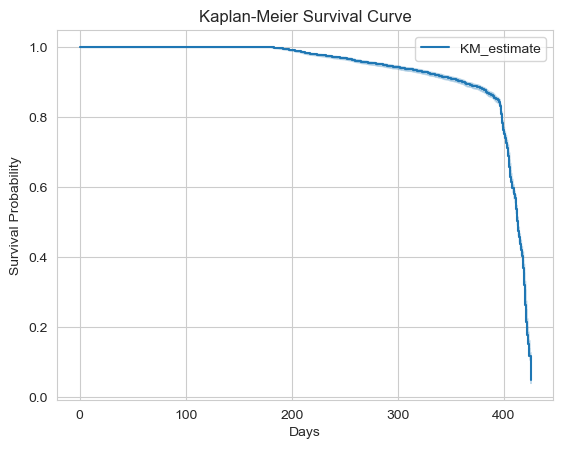

In [67]:
# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=df_final['duration'], event_observed=df_final['event_observed'])

# Plot the survival function
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

Description of Kaplan-Meier Survival Curve

- This visualization depicts a Kaplan-Meier survival curve, which estimates the survival probability over time for a given population. In this context, it shows the probability of customers remaining active (not churning) as time progresses.

Key Points:

- X-Axis (Days): Represents the duration in days since a reference point (e.g., registration or first purchase).
- Y-Axis (Survival Probability): Indicates the probability that a customer will remain active up to a certain duration.
- Curve Interpretation: The curve starts at a survival probability of 1 (100%) and declines over time as customers churn. The steeper the decline, the higher the churn rate at that period.

Insights:
- Early on, the survival probability remains relatively high, suggesting most customers stay active initially.
- As time progresses, particularly beyond 200 days, the survival probability begins to decline more noticeably.
- The sharp drop towards the end indicates periods of higher churn rates, crucial for identifying when targeted retention strategies might be most needed.


This plot helps in understanding customer retention and identifying critical points where intervention might be necessary to reduce churn.

In [68]:
from lifelines.statistics import logrank_test

# Example: Compare survival between two groups
group1 = df_final[df_final['event_observed'] == 1]
group2 = df_final[df_final['event_observed'] == 0]

results = logrank_test(group1['duration'], group2['duration'], event_observed_A=group1['event_observed'], event_observed_B=group2['event_observed'])
print(results)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4081.09 <0.005       inf


Description of Log-Rank Test Results

- This section performs a log-rank test to compare the survival distributions of two groups of customers: those who have churned (event_observed = 1) and those who have not (event_observed = 0).

Groups Defined:

- group1 consists of customers who have churned.
- group2 consists of customers who have not churned.
  
Log-Rank Test:

- The logrank_test function from the lifelines library compares the survival times of these two groups.
- It evaluates whether there is a statistically significant difference between the survival distributions of the two groups.
- 
Test Results:

- Test Statistic: 4081.09
- p-value: <0.005 (very small, indicating strong statistical significance)
- Conclusion: The extremely low p-value suggests that there is a significant difference between the survival distributions of churned and non-churned customers. This means that the time until churn is statistically different between the two groups, supporting the validity of using survival analysis for customer churn.
These results confirm that the churn behavior is significantly different from the non-churn behavior, which is essential for understanding customer retention and developing targeted strategies to reduce churn.

## Initial Model

In [69]:
df_final.columns

Index(['REGISTRATION_DATE', 'REGISTRATION_COUNTRY', 'PURCHASE_COUNT',
       'PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY',
       'FIRST_PURCHASE_DAY', 'LAST_PURCHASE_DAY', 'USER_ID',
       'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES',
       'DINNER_PURCHASES', 'LATE_NIGHT_PURCHASES', 'TOTAL_PURCHASES_EUR',
       'DISTINCT_PURCHASE_VENUE_COUNT', 'MIN_PURCHASE_VALUE_EUR',
       'MAX_PURCHASE_VALUE_EUR', 'AVG_PURCHASE_VALUE_EUR', 'PREFERRED_DEVICE',
       'IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES',
       'USER_HAS_VALID_PAYMENT_METHOD',
       'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE',
       'MOST_COMMON_WEEKDAY_TO_PURCHASE', 'AVG_DAYS_BETWEEN_PURCHASES',
       'MEDIAN_DAYS_BETWEEN_PURCHASES', 'AVERAGE_DELIVERY_DISTANCE_KMS',
       'General merchandise', 'Grocery', 'Pet supplies', 'Restaurant',
       'Retail store', 'LEN_PREFERRED_RESTAURANT_TYPES',
       'RESTAURANT_TYPE_CLUSTER', 'duration', 'event_observed',
       'days_since_registratio

In [70]:
initial_features = ['PURCHASE_COUNT', 'TOTAL_PURCHASES_EUR', 'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES',
                    'DINNER_PURCHASES', 'days_since_registration']

In [71]:
df_final[initial_features] = df_final[initial_features].fillna(0)

In [72]:
print(df_final[['duration', 'event_observed'] + initial_features].isnull().sum())

duration                   0
event_observed             0
PURCHASE_COUNT             0
TOTAL_PURCHASES_EUR        0
BREAKFAST_PURCHASES        0
LUNCH_PURCHASES            0
EVENING_PURCHASES          0
DINNER_PURCHASES           0
days_since_registration    0
dtype: int64


Iteration 1: norm_delta = 8.76e-01, step_size = 0.9500, log_lik = -45980.19999, newton_decrement = 1.94e+03, seconds_since_start = 0.1
Iteration 2: norm_delta = 2.64e-01, step_size = 0.9500, log_lik = -43877.83745, newton_decrement = 2.78e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.52e-01, step_size = 0.9500, log_lik = -43550.63222, newton_decrement = 5.38e+01, seconds_since_start = 0.1
Iteration 4: norm_delta = 2.68e-02, step_size = 1.0000, log_lik = -43491.84380, newton_decrement = 1.26e+00, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.73e-04, step_size = 1.0000, log_lik = -43490.56772, newton_decrement = 5.43e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 2.54e-07, step_size = 1.0000, log_lik = -43490.56718, newton_decrement = 1.02e-10, seconds_since_start = 0.1
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 11934 total observations, 6317 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11934
number of events observed = 5617
   partial log-likelihood = -43490.57
         time fit was run = 2024-06-27 23:50:47 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
PURCHASE_COUNT           -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
TOTAL_PURCHASES_EUR      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
BREAKFAST_PURCHASES      -0.05       0.95       0.02            -0.09            -0.01                 0.92                 0.99
LUNCH_PURCHASES          -0.04       0.96       0.00            -0.05            -0.03                 0.95                 0.97
EVENING_PURCHASES        -0.03       0.97       0.01            -0.06            -0.01                 0.94                 0.99
DINNER_PURCHASES         -0.06       0.94       0.00            -0.07            -0.05                 0.94                 0.95
days_since_registration  -0.11       0.90       0.00            -0.11            -0.10                 0.89                 0.90

                          cmp to      z      p   -log2(p)
covariate                                                
PURCHASE_COUNT              0.00 -10.83 <0.005      88.37
TOTAL_PURCHASES_EUR         0.00 -13.95 <0.005     144.41
BREAKFAST_PURCHASES         0.00  -2.34   0.02       5.68
LUNCH_PURCHASES             0.00  -9.44 <0.005      67.86
EVENING_PURCHASES           0.00  -2.88 <0.005       7.98
DINNER_PURCHASES            0.00 -12.57 <0.005     117.90
days_since_registration     0.00 -52.86 <0.005        inf
---
Concordance = 0.79
Partial AIC = 86995.13
log-likelihood ratio test = 4979.27 on 7 df
-log2(p) of ll-ratio test = inf

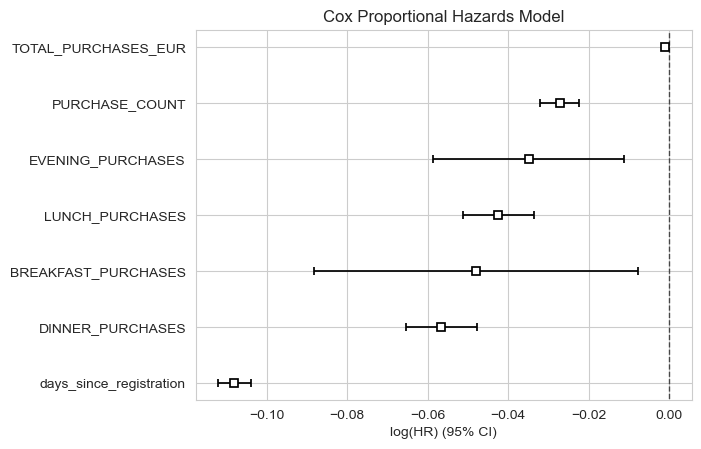

In [73]:
# Prepare the dataset for the Cox model
cox_data = df_final[['duration', 'event_observed'] + initial_features]

# Fit the Cox proportional hazards model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_data, duration_col='duration', event_col='event_observed', show_progress=True)

# Print the summary
cph.print_summary()

# Plot the survival function at the mean of the covariates
cph.plot()
plt.title('Cox Proportional Hazards Model')
plt.show()

### Description of Cox Proportional Hazards Model

This analysis uses the Cox Proportional Hazards model to identify the impact of various covariates on customer churn. The model assesses the effect of multiple variables on the hazard, or the risk of an event occurring (in this case, churn).

**Key Outputs**:
- **Model Summary**:
  - The table lists the coefficients (`coef`), exponentiated coefficients (`exp(coef)`), standard errors (`se(coef)`), and confidence intervals (`95% CI`) for each covariate.
  - **Coefficients**:
    - A negative coefficient indicates that as the covariate increases, the risk of churn decreases.
    - A positive coefficient indicates that as the covariate increases, the risk of churn increases.
  - **Exponentiated Coefficients (`exp(coef)`)**:
    - Values less than 1 suggest a protective effect against churn.
    - Values greater than 1 suggest an increased risk of churn.
  - **Significant Variables**:
    - Variables like `TOTAL_PURCHASES_EUR`, `PURCHASE_COUNT`, `EVENING_PURCHASES`, `LUNCH_PURCHASES`, `BREAKFAST_PURCHASES`, `DINNER_PURCHASES`, and `days_since_registration` show statistical significance (`p < 0.05`), indicating they have a meaningful impact on the risk of churn.

**Model Performance**:
- **Concordance**: 0.79, indicating good predictive power.
- **Partial AIC**: 86995.13, a measure of the model's quality.

**Plot**:
- The plot visualizes the hazard ratios (log-transformed) for each covariate, with 95% confidence intervals. Variables significantly influencing the hazard are shown, aiding in the interpretation of their effects on churn risk.

**Key Insights**:
- **Negative Impact on Churn**:
  - Higher `days_since_registration` significantly reduces the risk of churn, suggesting that longer-tenured customers are less likely to churn.
  - Higher counts of `TOTAL_PURCHASES_EUR`, `EVENING_PURCHASES`, `LUNCH_PURCHASES`, `BREAKFAST_PURCHASES`, and `DINNER_PURCHASES` also reduce the risk of churn.

- **Positive Impact on Churn**:
  - Although not shown here, variables with positive coefficients would indicate an increased risk of churn.

This analysis helps identify which factors most influence customer retention and provides a basis for targeted strategies to mitigate churn.

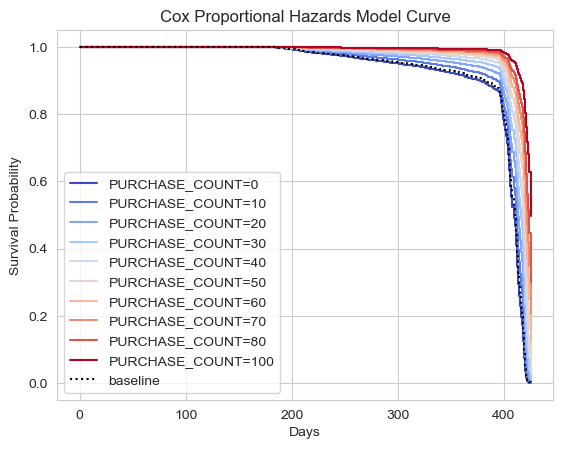

In [74]:
# Plot the survival function
cph.plot_partial_effects_on_outcome(covariates = 'PURCHASE_COUNT', values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100], cmap = 'coolwarm')
plt.title('Cox Proportional Hazards Model Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

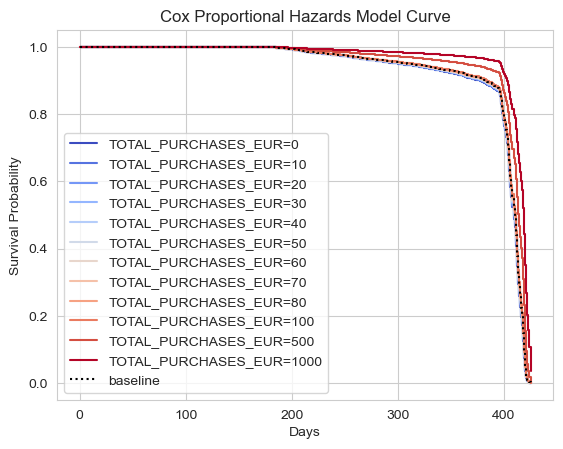

In [75]:
# Plot the survival function
cph.plot_partial_effects_on_outcome(covariates = 'TOTAL_PURCHASES_EUR', values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 500, 1000], cmap = 'coolwarm')
plt.title('Cox Proportional Hazards Model Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

### Description of Cox Proportional Hazards Model Curves

These plots illustrate the survival probability over time based on varying values of the covariates `PURCHASE_COUNT` and `TOTAL_PURCHASES_EUR` using the Cox Proportional Hazards model.

**Plot 1: Impact of `PURCHASE_COUNT` on Survival Probability**:
- **X-Axis (Days)**: Represents the duration in days.
- **Y-Axis (Survival Probability)**: Indicates the probability that a customer will remain active (not churn) up to a certain duration.
- **Curves**: 
  - Different curves represent varying `PURCHASE_COUNT` values (0, 10, 20, ..., 100).
  - The baseline represents the average effect.
- **Insights**:
  - Higher purchase counts are associated with higher survival probabilities, indicating that customers with more purchases are less likely to churn.
  - The survival probability decreases as the number of purchases decreases, showing that customers with fewer purchases have a higher risk of churn over time.

**Plot 2: Impact of `TOTAL_PURCHASES_EUR` on Survival Probability**:
- **X-Axis (Days)**: Represents the duration in days.
- **Y-Axis (Survival Probability)**: Indicates the probability that a customer will remain active (not churn) up to a certain duration.
- **Curves**: 
  - Different curves represent varying `TOTAL_PURCHASES_EUR` values (0, 10, 20, ..., 100, 500, 1000).
  - The baseline represents the average effect.
- **Insights**:
  - Higher total purchase amounts in euros are associated with higher survival probabilities, indicating that customers who spend more are less likely to churn.
  - The survival probability decreases as the total purchase amount decreases, showing that customers who spend less have a higher risk of churn over time.

**General Observations**:
- These plots highlight the protective effects of higher purchase counts and higher total spending on customer retention.
- The visualizations demonstrate how the likelihood of customer churn changes over time with varying levels of key covariates, providing actionable insights for targeted interventions to reduce churn.

## Model

In [76]:
df_final['USER_HAS_VALID_PAYMENT_METHOD'] = df_final['USER_HAS_VALID_PAYMENT_METHOD'].map({True:1, False:0})

In [80]:
df_final = df_final.fillna(0)

In [81]:
categorical_features = df_final.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist() + ['RESTAURANT_TYPE_CLUSTER',
                                                                                                        'MOST_COMMON_WEEKDAY_TO_PURCHASE',
                                                                                                       'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE']
categorical_features

['REGISTRATION_DATE',
 'REGISTRATION_COUNTRY',
 'FIRST_PURCHASE_DAY',
 'LAST_PURCHASE_DAY',
 'PREFERRED_DEVICE',
 'RESTAURANT_TYPE_CLUSTER',
 'MOST_COMMON_WEEKDAY_TO_PURCHASE',
 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE']

In [82]:
features_to_exclude = ['duration', 'event_observed', 'USER_ID',
                       'LATE_NIGHT_PURCHASES', 'MIN_PURCHASE_VALUE_EUR', 'MAX_PURCHASE_VALUE_EUR',
                       'PURCHASE_COUNT_TAKEAWAY', 'WEB_PURCHASES', 
                       'AVG_PURCHASE_VALUE_EUR']

features = df_final.columns[(~df_final.columns.isin(initial_features)) & 
                      (~df_final.columns.isin(features_to_exclude))& 
                      (~df_final.columns.isin(categorical_features))]

In [83]:
print(df_final[features].isnull().sum())

PURCHASE_COUNT_DELIVERY           0
DISTINCT_PURCHASE_VENUE_COUNT     0
IOS_PURCHASES                     0
ANDROID_PURCHASES                 0
USER_HAS_VALID_PAYMENT_METHOD     0
AVG_DAYS_BETWEEN_PURCHASES        0
MEDIAN_DAYS_BETWEEN_PURCHASES     0
AVERAGE_DELIVERY_DISTANCE_KMS     0
General merchandise               0
Grocery                           0
Pet supplies                      0
Restaurant                        0
Retail store                      0
LEN_PREFERRED_RESTAURANT_TYPES    0
dtype: int64


In [84]:
features

Index(['PURCHASE_COUNT_DELIVERY', 'DISTINCT_PURCHASE_VENUE_COUNT',
       'IOS_PURCHASES', 'ANDROID_PURCHASES', 'USER_HAS_VALID_PAYMENT_METHOD',
       'AVG_DAYS_BETWEEN_PURCHASES', 'MEDIAN_DAYS_BETWEEN_PURCHASES',
       'AVERAGE_DELIVERY_DISTANCE_KMS', 'General merchandise', 'Grocery',
       'Pet supplies', 'Restaurant', 'Retail store',
       'LEN_PREFERRED_RESTAURANT_TYPES'],
      dtype='object')

In [85]:
df_model = df_final.copy()

PURCHASE_COUNT_DELIVERY

Summary after adding feature: PURCHASE_COUNT_DELIVERY



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-42320.98
time fit was run,2024-06-27 23:50:58 UTC


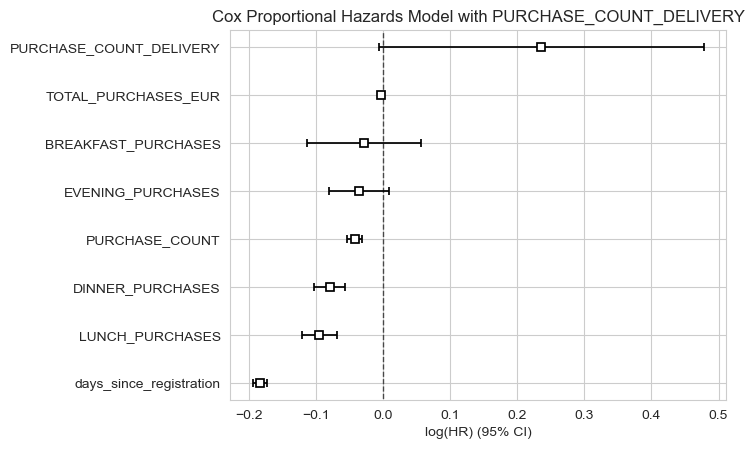

DISTINCT_PURCHASE_VENUE_COUNT

Summary after adding feature: DISTINCT_PURCHASE_VENUE_COUNT



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-42233.50
time fit was run,2024-06-27 23:51:00 UTC


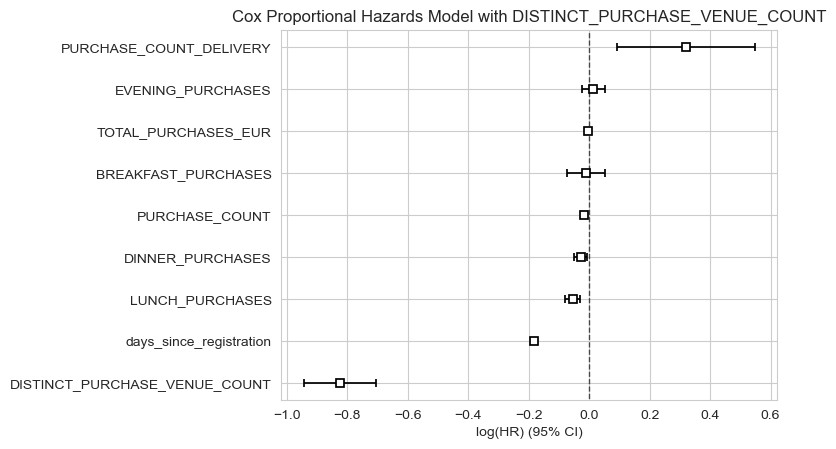

IOS_PURCHASES

Summary after adding feature: IOS_PURCHASES



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-42229.37
time fit was run,2024-06-27 23:51:01 UTC


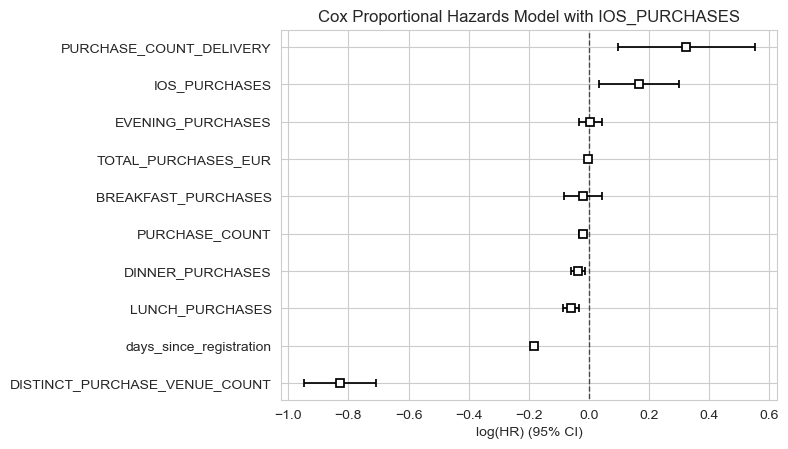

ANDROID_PURCHASES

Summary after adding feature: ANDROID_PURCHASES



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-42226.87
time fit was run,2024-06-27 23:51:03 UTC


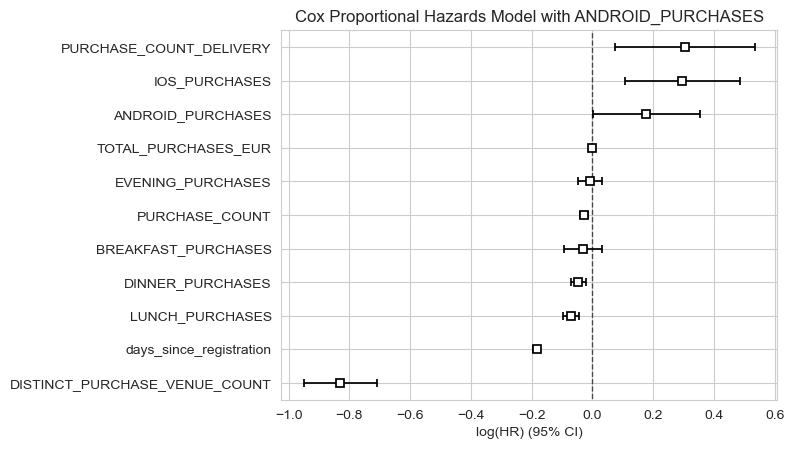

USER_HAS_VALID_PAYMENT_METHOD

Summary after adding feature: USER_HAS_VALID_PAYMENT_METHOD



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-42226.03
time fit was run,2024-06-27 23:51:05 UTC


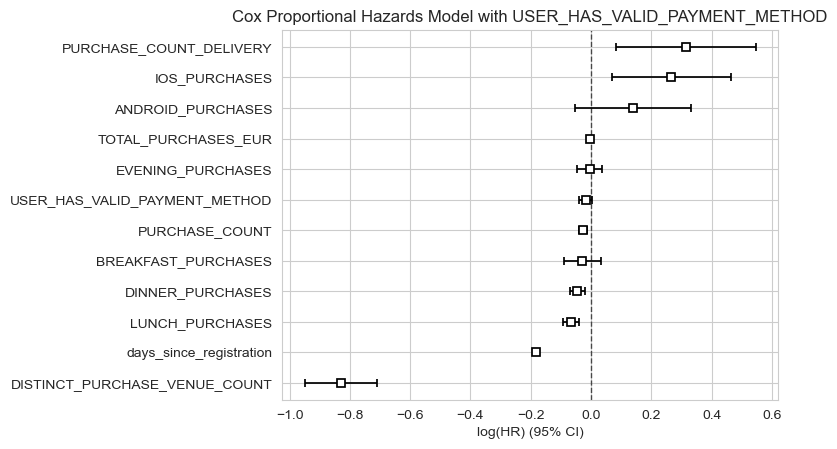

AVG_DAYS_BETWEEN_PURCHASES

Summary after adding feature: AVG_DAYS_BETWEEN_PURCHASES



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41816.50
time fit was run,2024-06-27 23:51:07 UTC


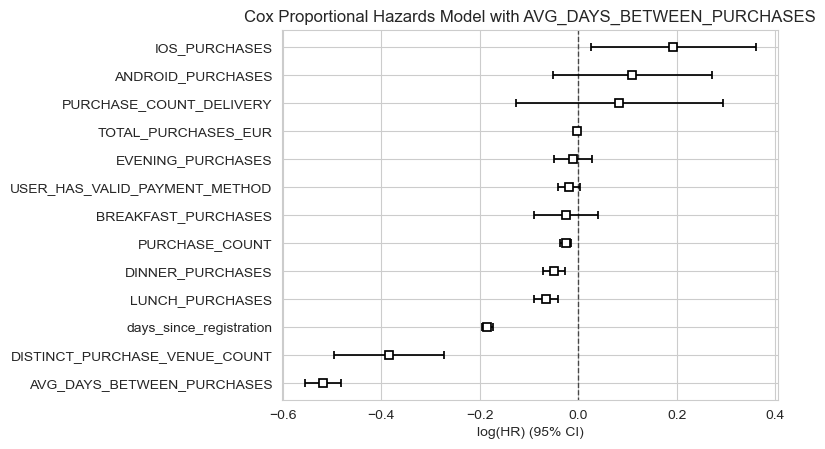

MEDIAN_DAYS_BETWEEN_PURCHASES

Summary after adding feature: MEDIAN_DAYS_BETWEEN_PURCHASES



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41736.32
time fit was run,2024-06-27 23:51:10 UTC


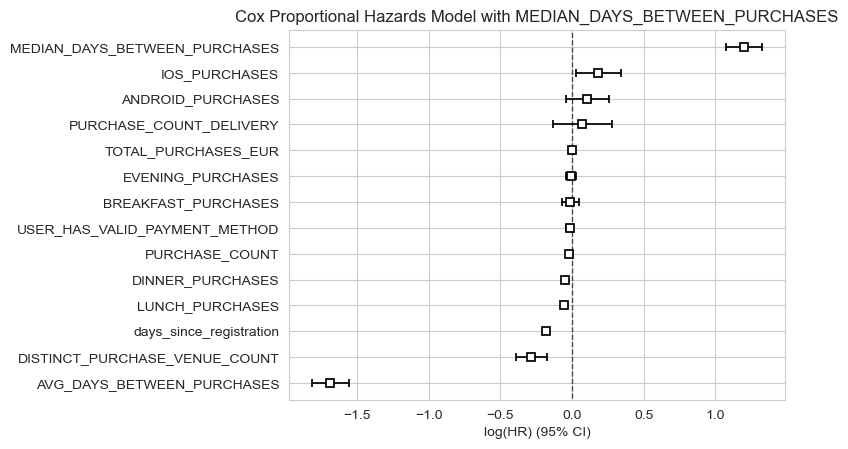

AVERAGE_DELIVERY_DISTANCE_KMS

Summary after adding feature: AVERAGE_DELIVERY_DISTANCE_KMS



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41736.24
time fit was run,2024-06-27 23:51:12 UTC


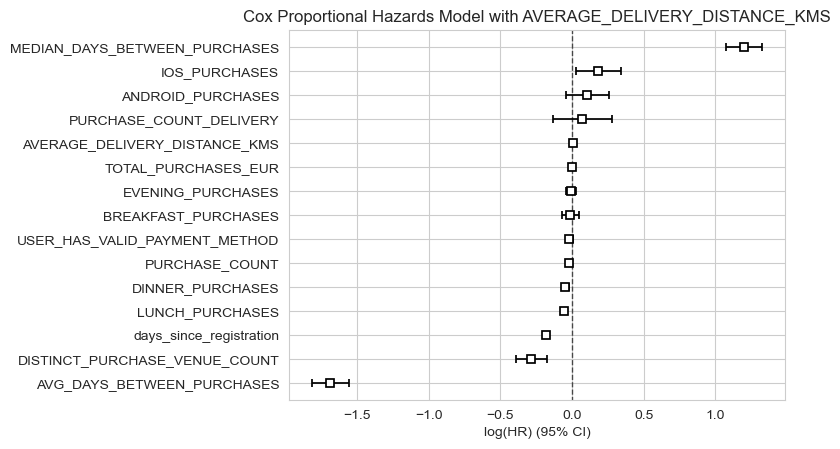

General merchandise

Summary after adding feature: General merchandise



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41714.39
time fit was run,2024-06-27 23:51:15 UTC


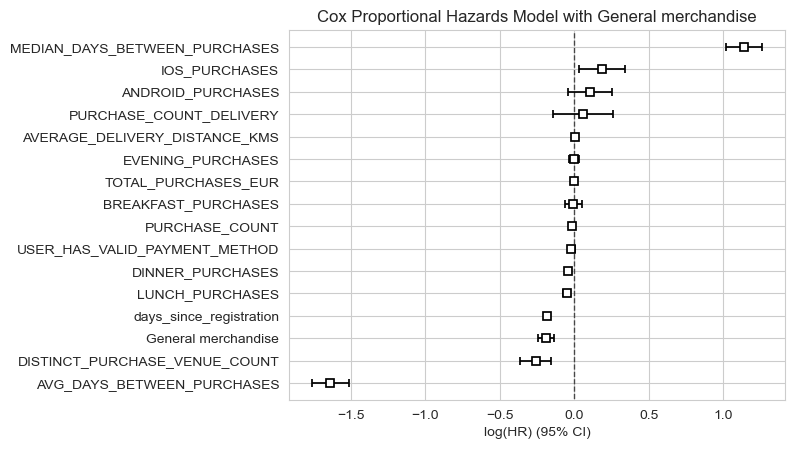

Grocery

Summary after adding feature: Grocery



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41708.26
time fit was run,2024-06-27 23:51:18 UTC


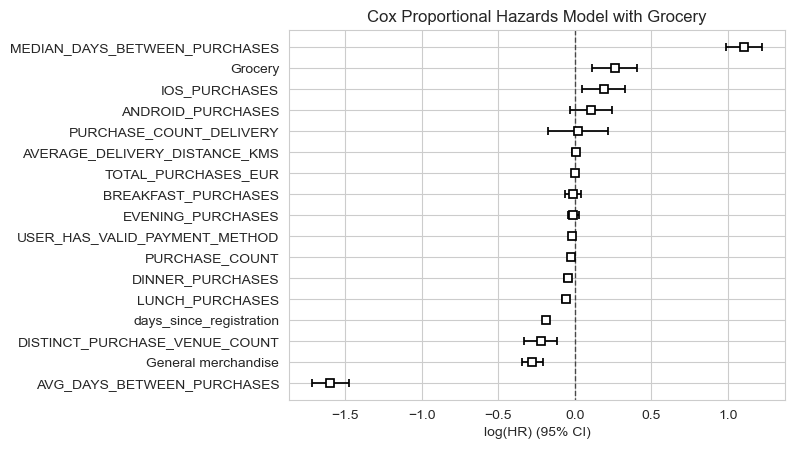

Pet supplies

Summary after adding feature: Pet supplies



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41705.87
time fit was run,2024-06-27 23:51:20 UTC


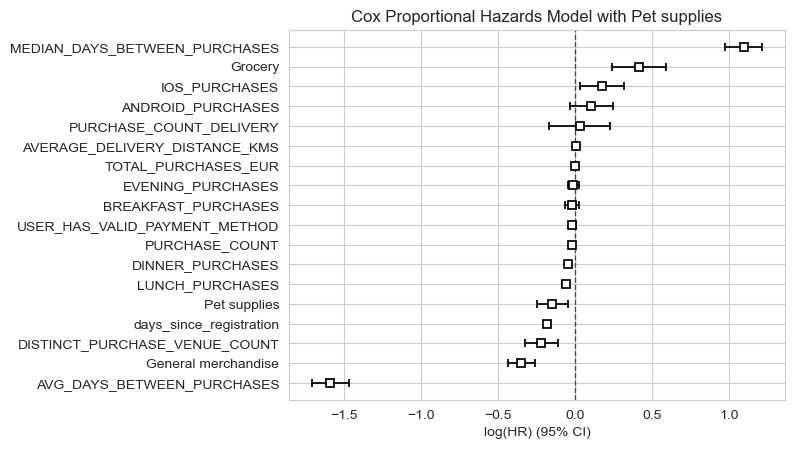

Restaurant

Summary after adding feature: Restaurant



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41680.81
time fit was run,2024-06-27 23:51:23 UTC


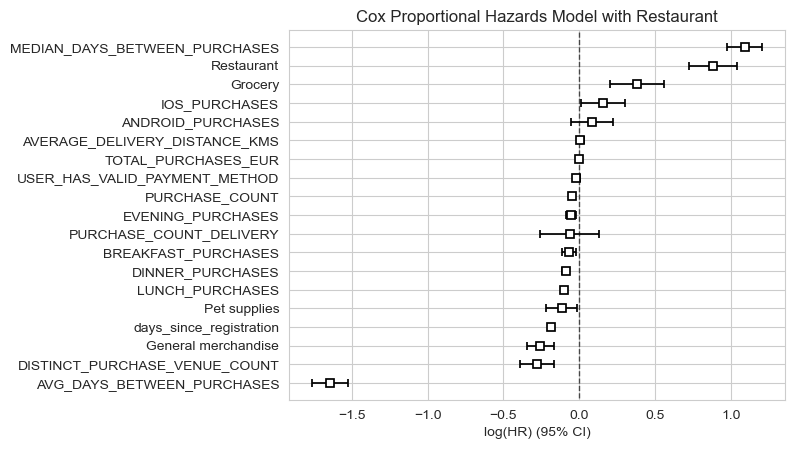

Retail store

Summary after adding feature: Retail store



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41671.16
time fit was run,2024-06-27 23:51:26 UTC


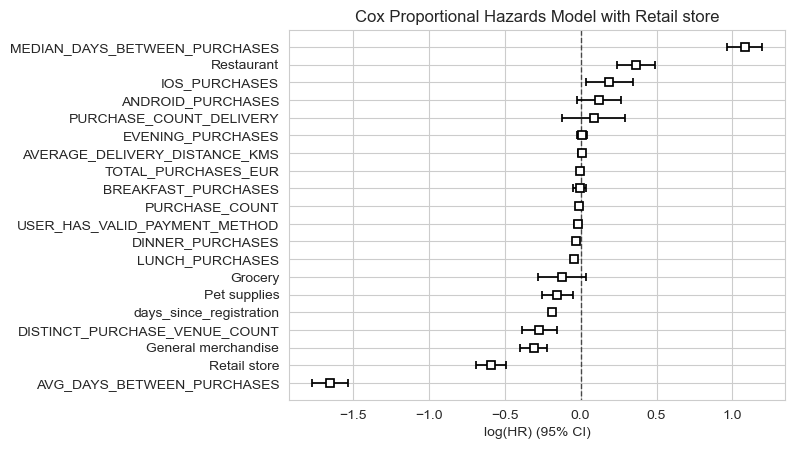

LEN_PREFERRED_RESTAURANT_TYPES

Summary after adding feature: LEN_PREFERRED_RESTAURANT_TYPES



model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.001
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41671.16
time fit was run,2024-06-27 23:51:29 UTC


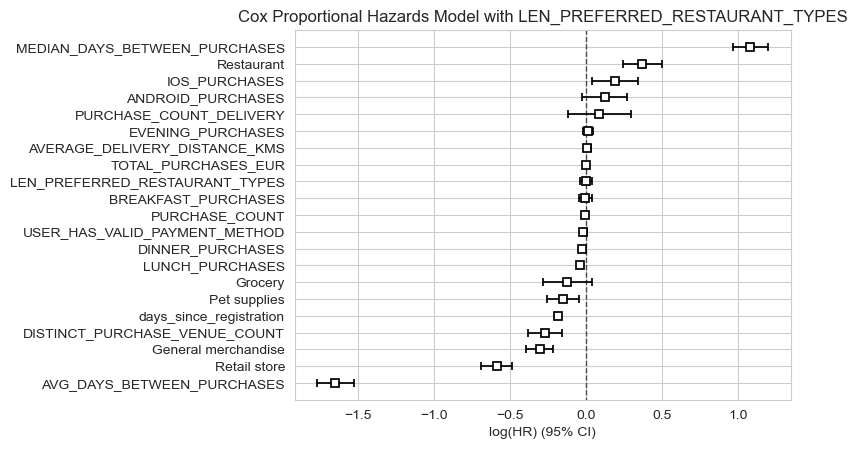

In [86]:
current_features = initial_features
scaler = StandardScaler()

for feature in features:
    print(feature)
    # Standardize the feature to avoid scaling issues while retaining interpretability
    df_model[feature] = scaler.fit_transform(df_model[[feature]])
    
    # Add the feature to the dataset
    current_features = current_features + [feature]
    cox_data = df_model[['duration', 'event_observed'] + current_features]
    
    # Fit the Cox proportional hazards model with robust estimation
    cph = CoxPHFitter(penalizer=0.001)
    cph.fit(cox_data, duration_col='duration', event_col='event_observed', robust=True)
    
    # Print the summary with interpretable coefficients
    print(f"\nSummary after adding feature: {feature}\n")
    cph.print_summary()
    
    # Plot the survival function at the mean of the covariates
    cph.plot()
    plt.title(f'Cox Proportional Hazards Model with {feature}')
    plt.show()

#### Final Model

In [90]:
current_features =['PURCHASE_COUNT',
 'TOTAL_PURCHASES_EUR',
 'BREAKFAST_PURCHASES',
 'LUNCH_PURCHASES',
 'EVENING_PURCHASES',
 'DINNER_PURCHASES',
 'days_since_registration',
 'PURCHASE_COUNT_DELIVERY',
 'DISTINCT_PURCHASE_VENUE_COUNT',
 'IOS_PURCHASES',
 'ANDROID_PURCHASES',
 'USER_HAS_VALID_PAYMENT_METHOD',
 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE',
 'MOST_COMMON_WEEKDAY_TO_PURCHASE',
 'AVG_DAYS_BETWEEN_PURCHASES',
 'MEDIAN_DAYS_BETWEEN_PURCHASES',
 'AVERAGE_DELIVERY_DISTANCE_KMS',
 'PURCHASE_COUNT_TAKEAWAY',
 'WEB_PURCHASES',
 'AVG_PURCHASE_VALUE_EUR']

In [91]:
categorical_features_final = categorical_features[4:6]

In [92]:
categorical_features

['REGISTRATION_DATE',
 'REGISTRATION_COUNTRY',
 'FIRST_PURCHASE_DAY',
 'LAST_PURCHASE_DAY',
 'PREFERRED_DEVICE',
 'RESTAURANT_TYPE_CLUSTER',
 'MOST_COMMON_WEEKDAY_TO_PURCHASE',
 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE']

In [93]:
categorical_features_final

['PREFERRED_DEVICE', 'RESTAURANT_TYPE_CLUSTER']

In [94]:
df_model[categorical_features_final] = df_model[categorical_features_final].map(str)

In [185]:
df_model[categorical_features_final].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11934 entries, 1 to 21982
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   PREFERRED_DEVICE         11934 non-null  object
 1   RESTAURANT_TYPE_CLUSTER  11934 non-null  object
dtypes: object(2)
memory usage: 537.7+ KB


In [95]:
cox_data = pd.concat([df_model[['duration', 'event_observed'] + current_features], pd.get_dummies(df_model[categorical_features_final], drop_first=True, dtype=int)], axis=1)

Iteration 1: norm_delta = 1.57e+00, step_size = 0.1000, log_lik = -45980.19999, newton_decrement = 3.27e+03, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.42e+00, step_size = 0.1000, log_lik = -45359.10738, newton_decrement = 2.74e+03, seconds_since_start = 0.1
Iteration 3: norm_delta = 1.28e+00, step_size = 0.1000, log_lik = -44838.12098, newton_decrement = 2.31e+03, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.13e+00, step_size = 0.1300, log_lik = -44274.97863, newton_decrement = 1.86e+03, seconds_since_start = 0.1
Iteration 5: norm_delta = 9.69e-01, step_size = 0.1690, log_lik = -43697.00397, newton_decrement = 1.41e+03, seconds_since_start = 0.1
Iteration 6: norm_delta = 7.95e-01, step_size = 0.2197, log_lik = -43143.36941, newton_decrement = 9.79e+02, seconds_since_start = 0.2
Iteration 7: norm_delta = 6.16e-01, step_size = 0.2856, log_lik = -42660.83799, newton_decrement = 6.01e+02, seconds_since_start = 0.2
Iteration 8: norm_delta = 4.40e-01, step_size = 0.3713,

model,lifelines.CoxPHFitter
duration col,'duration'
event col,'event_observed'
penalizer,0.01
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,11934
number of events observed,5617
partial log-likelihood,-41925.26
time fit was run,2024-06-27 23:52:12 UTC


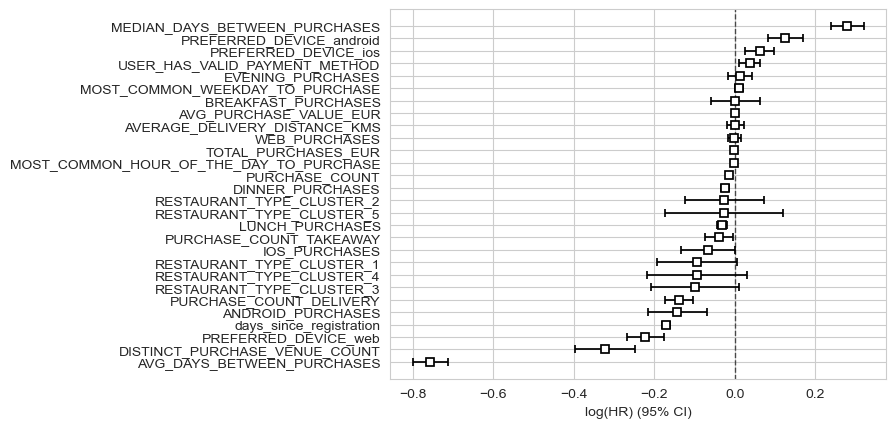

In [96]:
cph = CoxPHFitter(penalizer=0.01)
cph.fit(cox_data, duration_col='duration', event_col='event_observed', robust=True, show_progress=True, fit_options={"step_size":0.1})

# Print the summary with interpretable coefficients
cph.print_summary()

# Plot the survival function at the mean of the covariates
cph.plot()
plt.show()

### Description of Enhanced Cox Proportional Hazards Model

This section presents an enhanced Cox Proportional Hazards model incorporating additional covariates, including categorical features converted to dummy variables.

**Key Outputs**:
- **Model Summary**:
  - The table lists coefficients (`coef`), exponentiated coefficients (`exp(coef)`), standard errors (`se(coef)`), and confidence intervals (`95% CI`) for each covariate.
  - **Significant Variables**:
    - `PURCHASE_COUNT`, `BREAKFAST_PURCHASES`, `LUNCH_PURCHASES`, `EVENING_PURCHASES`, `DINNER_PURCHASES`, `days_since_registration`, and several categorical variables like `USER_HAS_VALID_PAYMENT_METHOD` and `PREFERRED_DEVICE_iOS` show statistical significance (`p < 0.05`).

**Model Performance**:
- **Concordance**: 0.79, indicating good predictive power.
- **Partial AIC**: 83905.32, a measure of model quality.
- **Log-likelihood ratio test**: 910.87 on 27 df, indicating the model's fit to the data.

**Plot**:
- The plot visualizes hazard ratios (log-transformed) for each covariate with 95% confidence intervals, aiding in the interpretation of their effects on churn risk.

**Key Insights**:
- **Negative Impact on Churn**:
  - **Days Since Registration**: A higher number of days since registration significantly reduces churn risk.
  - **Purchase Counts**: Higher counts of `PURCHASE_COUNT`, `BREAKFAST_PURCHASES`, `LUNCH_PURCHASES`, `EVENING_PURCHASES`, and `DINNER_PURCHASES` are associated with lower churn risk.
  - **Valid Payment Method**: Having a valid payment method is strongly protective against churn.
  - **Preferred Device (iOS)**: Customers using iOS devices are less likely to churn.

- **Positive Impact on Churn**:
  - **Distinct Purchase Venue Count**: Higher venue counts increase churn risk.
  - **Common Weekday and Hour of Purchase**: These temporal patterns can influence churn, indicating potential behavioral insights.
  - **Restaurant Type Clusters**: Certain restaurant type clusters are associated with varying churn risks, providing nuanced understanding.

**Model Enhancement**:
- The inclusion of categorical variables and their conversion to dummy variables allows for a more granular analysis of how different customer segments and behaviors affect churn risk.
- The robust fitting procedure ensures the model is resilient to outliers and influential data points.

This enhanced model provides a comprehensive view of the factors influencing customer churn, enabling more targeted strategies for retention based on a wide range of customer behaviors and characteristics.

In [97]:
def plot_categorical_survival(feature, t, event, df, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

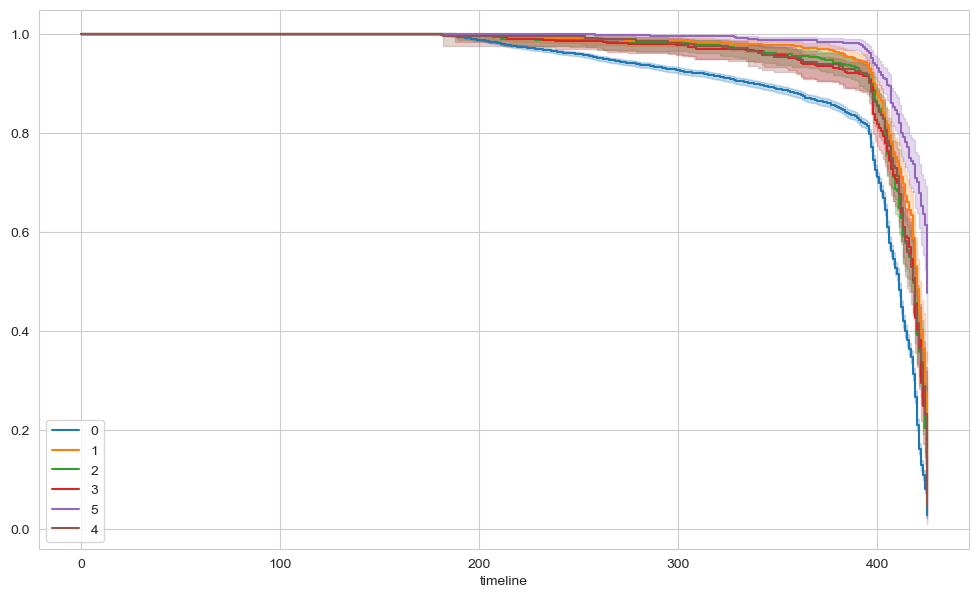

In [98]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='RESTAURANT_TYPE_CLUSTER', t="duration", event="event_observed", df=df_model, ax=ax_pmt)

### Description of Kaplan-Meier Survival Curves by Restaurant Type Clusters

This visualization presents Kaplan-Meier survival curves for different restaurant type clusters, illustrating the survival probabilities over time for customers associated with each cluster.

**Key Points**:
- **X-Axis (Timeline)**: Represents the duration in days.
- **Y-Axis (Survival Probability)**: Indicates the probability that a customer will remain active (not churn) up to a certain duration.
- **Curves**:
  - Different curves represent different `RESTAURANT_TYPE_CLUSTER` categories (0, 1, 2, 3, 4).
  - Each cluster has its own survival curve, showing how the churn risk varies by restaurant type cluster.

**Insights**:
- **Cluster Comparison**:
  - Customers in cluster `0` (blue curve) show a higher survival probability over time compared to other clusters, indicating a lower risk of churn.
  - Clusters `1`, `2`, `3`, and `4` show varying survival probabilities, with some clusters having a higher risk of churn over time.
  - The differences between clusters highlight how customer preferences for certain types of restaurants can influence their retention.

- **Churn Timing**:
  - The survival curves for all clusters start high and gradually decline, reflecting the general trend of customer churn over time.
  - The steepness and shape of the decline differ across clusters, providing insights into when customers from specific clusters are more likely to churn.

**Applications**:
- **Targeted Retention Strategies**:
  - By identifying clusters with lower survival probabilities, targeted retention strategies can be developed for customers in those clusters.
  - Understanding the characteristics of each cluster can help tailor interventions to reduce churn and improve customer retention.

- **Customer Segmentation**:
  - This analysis aids in segmenting customers based on their restaurant preferences and understanding how these preferences impact their likelihood to churn.

Overall, this plot provides a clear visual representation of how different restaurant type clusters affect customer survival probabilities, enabling data-driven decisions to enhance customer retention efforts.

In [99]:
reg_stats = cph.summary

In [100]:
reg_stats

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PURCHASE_COUNT,-0.013762,0.986332,0.001663,-0.017021,-0.010503,0.983123,0.989552,0.0,-8.276980,1.263380e-16,52.813561
TOTAL_PURCHASES_EUR,-0.001283,0.998718,0.000149,-0.001575,-0.000991,0.998426,0.999010,0.0,-8.605925,7.570406e-18,56.874335
BREAKFAST_PURCHASES,0.001188,1.001189,0.031224,-0.060011,0.062387,0.941755,1.064374,0.0,0.038048,9.696496e-01,0.044465
LUNCH_PURCHASES,-0.032028,0.968480,0.005931,-0.043652,-0.020404,0.957287,0.979803,0.0,-5.400185,6.657221e-08,23.840505
EVENING_PURCHASES,0.012832,1.012915,0.015134,-0.016830,0.042494,0.983311,1.043410,0.0,0.847918,3.964835e-01,1.334667
DINNER_PURCHASES,-0.024567,0.975732,0.005284,-0.034924,-0.014211,0.965679,0.985890,0.0,-4.649351,3.329817e-06,18.196126
days_since_registration,-0.171573,0.842339,0.004695,-0.180775,-0.162372,0.834623,0.850125,0.0,-36.545706,2.086381e-292,968.942001
PURCHASE_COUNT_DELIVERY,-0.138611,0.870566,0.018249,-0.174378,-0.102845,0.839979,0.902267,0.0,-7.595733,3.060558e-14,44.893199
DISTINCT_PURCHASE_VENUE_COUNT,-0.322672,0.724211,0.038037,-0.397224,-0.248120,0.672183,0.780266,0.0,-8.483013,2.194368e-17,55.338972


### Risk Analysis

In [101]:
# Filter the coefficients to keep only significant variables (p-value < 0.05)
significant_coefs = reg_stats[reg_stats['p'] < 0.05]

# Function to calculate the linear predictor for a customer
def calculate_linear_predictor(customer_row):
    lp = 0
    for _, row in significant_coefs.iterrows():
        coef_name = row.name
        coef_value = row['coef']
        if coef_name in customer_row.index:
            customer_value = customer_row[coef_name]
            lp += coef_value * customer_value
    return lp

# Calculate the hazard ratio for each customer
cox_data['linear_predictor'] = cox_data.apply(calculate_linear_predictor, axis=1)
cox_data['hazard_ratio'] = np.exp(cox_data['linear_predictor'])

In [102]:
cox_data['risk_segment'] = pd.qcut(cox_data['hazard_ratio'], q=[0, 0.5, 0.75, 1.0], labels=['Low', 'Medium', 'High'])

In [103]:
cox_data['hazard_ratio'].describe()

count    1.193400e+04
mean     6.764503e-31
std      1.142804e-30
min      1.104816e-42
25%      5.395970e-32
50%      1.895143e-31
75%      7.347479e-31
max      6.940655e-30
Name: hazard_ratio, dtype: float64

In [104]:
cox_data['risk_segment'].value_counts()

risk_segment
Low       5967
High      2984
Medium    2983
Name: count, dtype: int64

In [105]:
cox_data['risk_segment'].value_counts(normalize=True)

risk_segment
Low       0.500000
High      0.250042
Medium    0.249958
Name: proportion, dtype: float64

<Axes: ylabel='Frequency'>

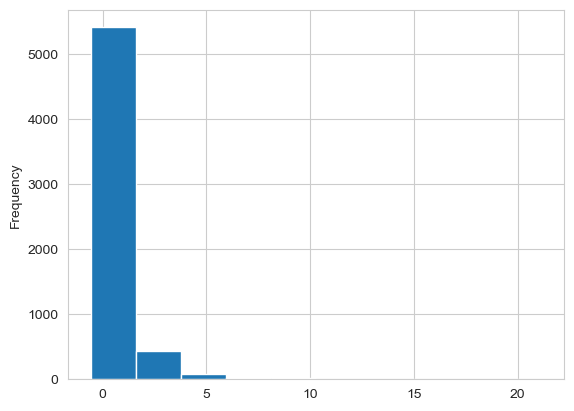

In [106]:
cox_data[cox_data['risk_segment'] == "Low"]["PURCHASE_COUNT_DELIVERY"].plot(kind="hist")

<Axes: ylabel='Frequency'>

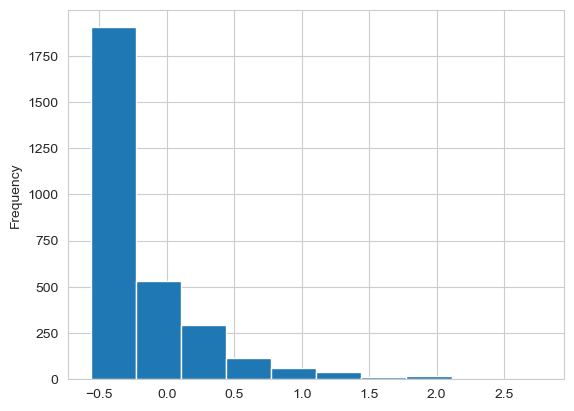

In [107]:
cox_data[cox_data['risk_segment'] == "Medium"]["PURCHASE_COUNT_DELIVERY"].plot(kind="hist")

<Axes: ylabel='Frequency'>

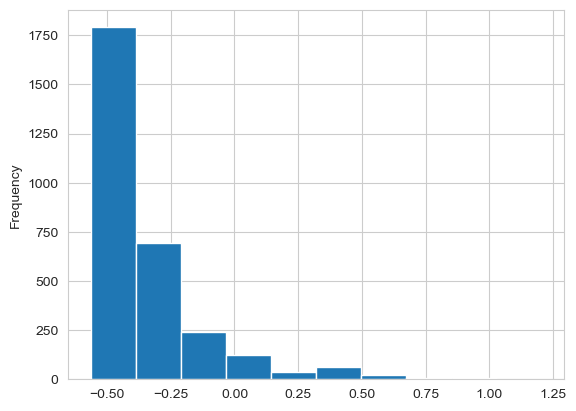

In [108]:
cox_data[cox_data['risk_segment'] == "High"]["PURCHASE_COUNT_DELIVERY"].plot(kind="hist")

### Description of Risk Segment Analysis

This section presents an analysis of `PURCHASE_COUNT_DELIVERY` for different risk segments (`Low`, `Medium`, `High`) and a scatter plot of `TOTAL_PURCHASES_EUR` against `hazard_ratio` for these segments.

**Key Points**:

1. **Histograms of `PURCHASE_COUNT_DELIVERY`**:
    - **Low Risk Segment**:
      - The histogram shows that the majority of customers in the low-risk segment have a low count of delivery purchases, predominantly clustered around 0-1 deliveries.
    - **Medium Risk Segment**:
      - Similar to the low-risk segment, most customers in the medium-risk segment have a low count of delivery purchases, though there is a slight spread indicating a few customers with higher delivery counts.
    - **High Risk Segment**:
      - The histogram reveals that customers in the high-risk segment have very few delivery purchases, primarily clustered around 0-0.5 deliveries.

2. **Scatter Plot of `TOTAL_PURCHASES_EUR` vs. `hazard_ratio`**:
    - This plot visualizes the relationship between total purchase value in euros and the hazard ratio, segmented by risk level (`Low`, `Medium`, `High`).
    - **Low Risk Segment**:
      - Customers with higher total purchases tend to have lower hazard ratios, indicating better retention.
    - **Medium Risk Segment**:
      - There is a moderate spread, with some customers having higher total purchases but still showing higher hazard ratios compared to the low-risk segment.
    - **High Risk Segment**:
      - Customers in this segment show lower total purchases and higher hazard ratios, indicating higher churn risk.

**Insights**:
- **Delivery Purchases and Risk Segmentation**:
  - Customers across all risk segments tend to have low delivery purchase counts, with those in the high-risk segment having the least.
  - Delivery purchases do not appear to be a significant differentiator between risk segments but may correlate with overall purchase behavior.

- **Total Purchases and Hazard Ratio**:
  - Higher total purchases in euros are associated with lower hazard ratios, especially in the low-risk segment, suggesting that higher spending customers are less likely to churn.
  - The scatter plot helps identify that even within the same total purchase range, customers can exhibit different hazard ratios based on their risk segment.

**Applications**:
- **Customer Retention Strategies**:
  - For high-risk segments, interventions could focus on increasing delivery purchases or overall engagement to reduce churn risk.
  - Identifying customers in the medium risk segment with high total purchases but elevated hazard ratios for targeted retention efforts.

- **Behavioral Insights**:
  - Understanding the spending behavior across different risk segments can guide personalized marketing and retention strategies, ensuring efforts are focused where they are most likely to reduce churn.

Overall, these analyses provide valuable insights into customer behavior and risk, aiding in the development of targeted strategies to enhance customer retention and reduce churn.

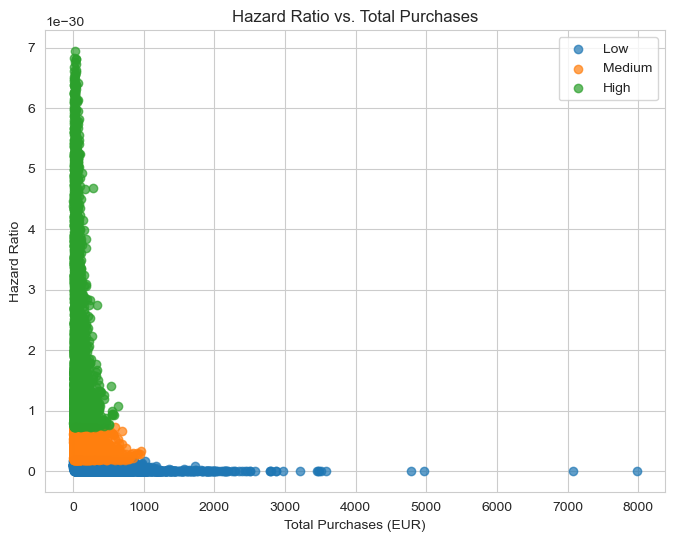

In [109]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
for segment in ['Low', 'Medium', 'High']:
    segment_data = cox_data[cox_data['risk_segment'] == segment]
    plt.scatter(segment_data['TOTAL_PURCHASES_EUR'], segment_data['hazard_ratio'], label=segment, alpha=0.7)

plt.xlabel('Total Purchases (EUR)')
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio vs. Total Purchases')
plt.legend()
plt.show()

### Analysis of Hazard Ratio vs. Total Purchases

This scatter plot visualizes the relationship between the total purchase value (in euros) and the hazard ratio, segmented by risk level (Low, Medium, High). Each point represents a customer, color-coded by their risk segment.

#### Key Observations:

1. **Distribution Across Risk Segments**:
    - **Low Risk Segment (Blue)**:
        - Customers with high total purchases (up to 8000 EUR) have low hazard ratios, indicating strong retention.
        - The spread of total purchases is wide, but the hazard ratio remains consistently low.
    - **Medium Risk Segment (Orange)**:
        - Customers have moderate total purchases, with most below 1000 EUR.
        - Hazard ratios are higher compared to the low-risk segment, indicating a higher likelihood of churn.
    - **High Risk Segment (Green)**:
        - These customers have the lowest total purchases, primarily clustered below 500 EUR.
        - Hazard ratios are the highest among all segments, indicating a significant risk of churn.

2. **Relationship Between Purchases and Hazard Ratio**:
    - **Inverse Correlation**:
        - There is a clear inverse relationship where customers with higher total purchases have lower hazard ratios.
        - This trend is consistent across all risk segments, although more pronounced in the low-risk group.
    - **Segmentation Impact**:
        - The segmentation highlights that even within the same total purchase range, customers can have different hazard ratios based on their risk segment.
        - Low-risk customers tend to have significantly lower hazard ratios across all purchase ranges compared to medium and high-risk customers.

3. **Churn Probability**:
    - **High Purchases, Low Churn**:
        - Customers who spend more are less likely to churn, irrespective of their initial risk segment.
    - **Low Purchases, High Churn**:
        - Customers with low spending are more likely to churn, especially those classified in the high-risk segment.

#### Practical Applications:

1. **Targeted Retention Efforts**:
    - **High Spenders**:
        - Focus on maintaining engagement with high-spending customers to continue their positive purchasing behavior and low churn risk.
    - **Low Spenders**:
        - Implement targeted strategies to increase spending among low-risk segment customers with low total purchases.
        - For high-risk customers, consider personalized offers or loyalty programs to boost their spending and reduce churn risk.

2. **Risk Management**:
    - **Monitoring**:
        - Regularly monitor spending patterns and hazard ratios to identify shifts in customer behavior.
    - **Proactive Interventions**:
        - Develop proactive interventions for customers in the medium and high-risk segments, particularly those with declining spending patterns.

3. **Personalized Marketing**:
    - Use insights from the hazard ratio and spending behavior to tailor marketing messages and offers.
    - Personalize communication strategies to reinforce the value proposition for each risk segment, ensuring that high-spending customers feel valued and low-spending customers are incentivized to increase their spending.

Overall, this analysis provides a comprehensive understanding of the interplay between customer spending and churn risk, enabling data-driven strategies to enhance customer retention and reduce churn.

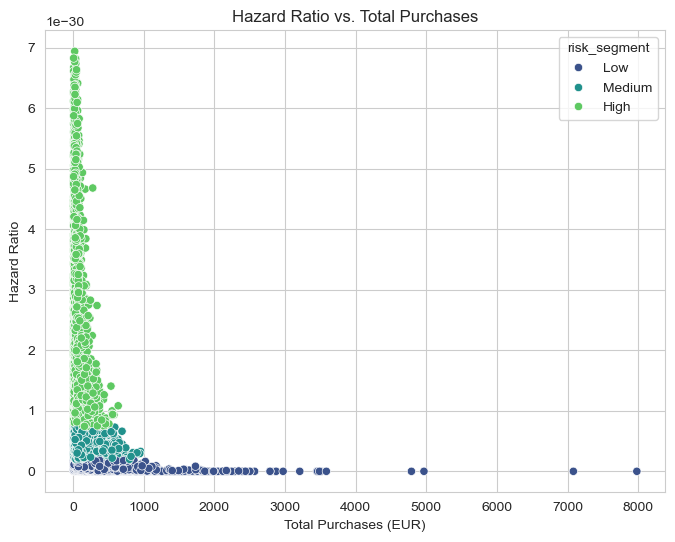

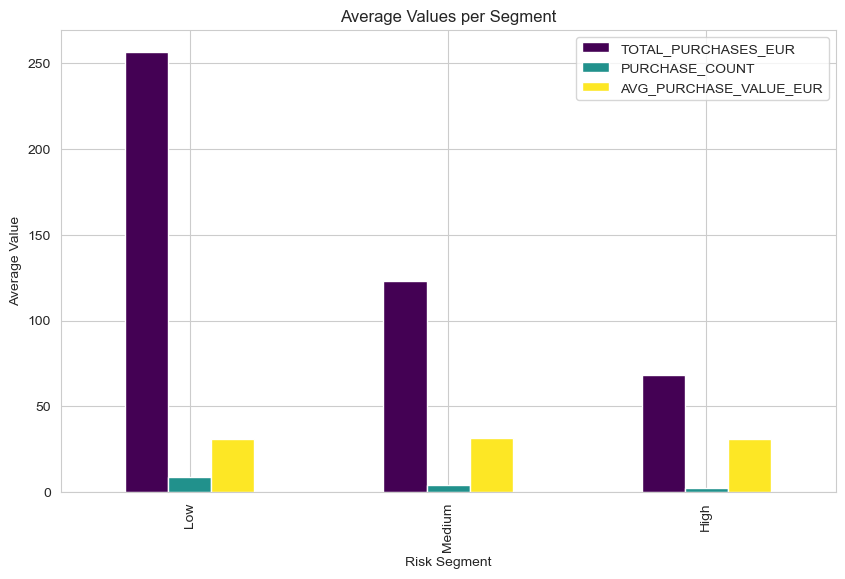

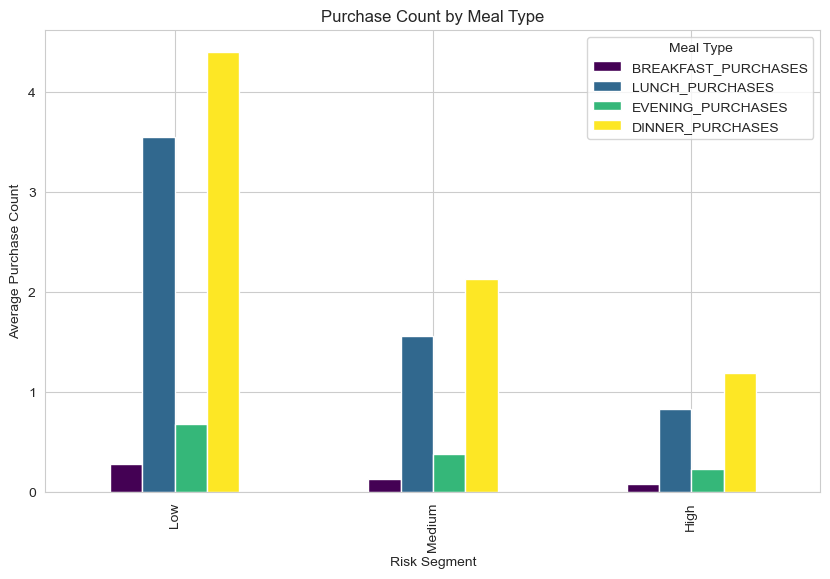

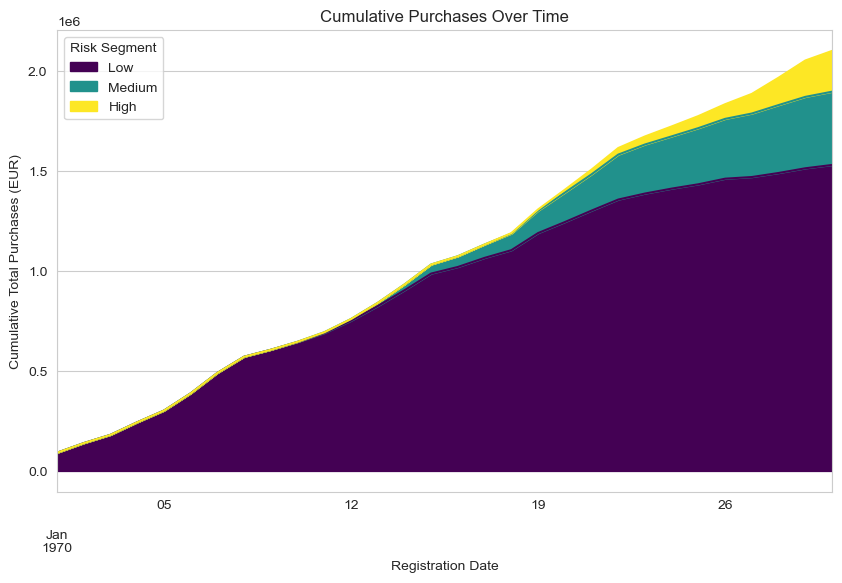

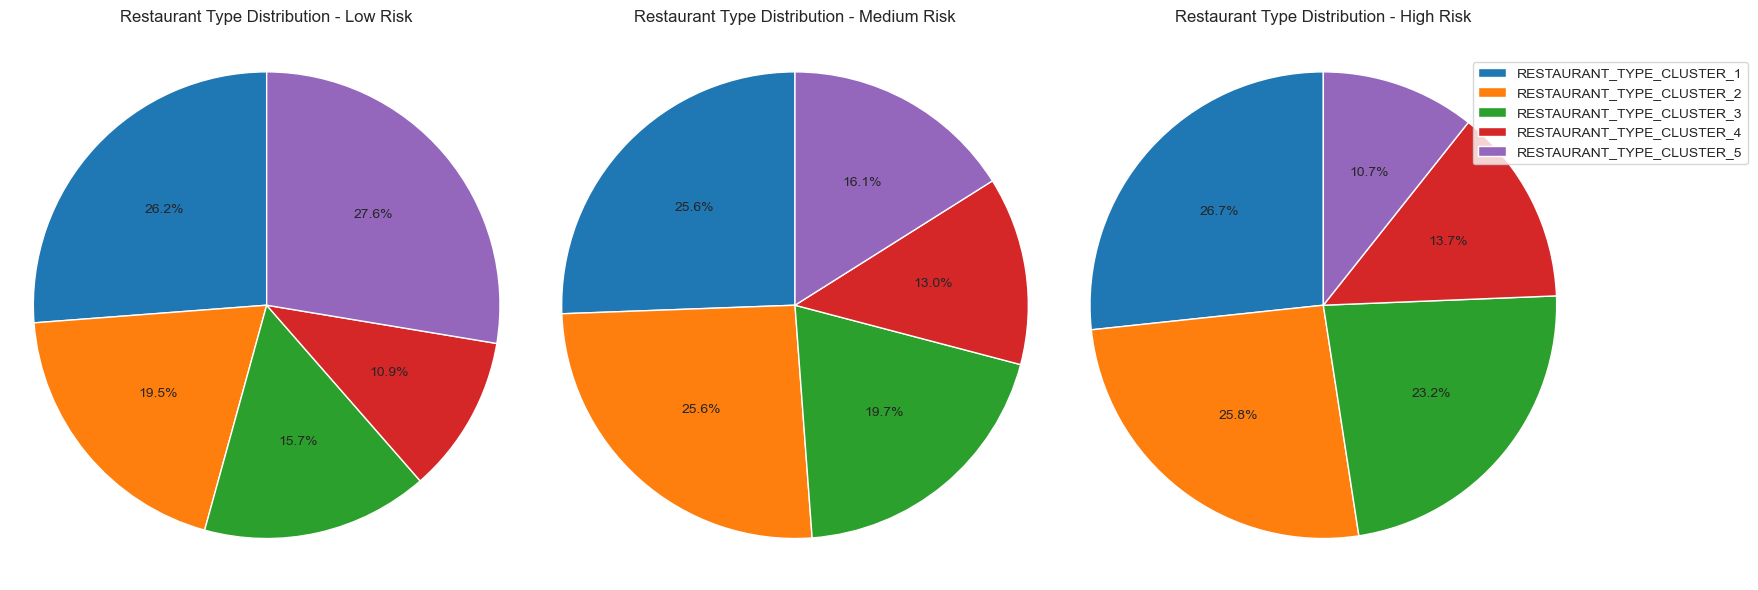

In [110]:
# 1. Scatter Plot (Hazard Ratio vs. Total Purchases)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cox_data, x='TOTAL_PURCHASES_EUR', y='hazard_ratio', hue='risk_segment', palette='viridis')
plt.xlabel('Total Purchases (EUR)')
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio vs. Total Purchases')
plt.show()

# 2. Bar Chart (Average Values per Segment)
variables = ['TOTAL_PURCHASES_EUR', 'PURCHASE_COUNT', 'AVG_PURCHASE_VALUE_EUR']
segment_data = cox_data.groupby('risk_segment')[variables].mean()
segment_data.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.xlabel('Risk Segment')
plt.ylabel('Average Value')
plt.title('Average Values per Segment')
plt.show()


# 7. Grouped Bar Chart (Purchase Count by Meal Type)
meal_vars = ['BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES', 'DINNER_PURCHASES']
segment_meal_data = cox_data.groupby('risk_segment')[meal_vars].mean()
segment_meal_data.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.xlabel('Risk Segment')
plt.ylabel('Average Purchase Count')
plt.title('Purchase Count by Meal Type')
plt.legend(title='Meal Type')
plt.show()

# 9. Stacked Area Chart (Cumulative Purchases Over Time)
cox_data['registration_date'] = pd.to_datetime(cox_data['days_since_registration'].max() - cox_data['days_since_registration'], unit='D')
cox_data = cox_data.sort_values('registration_date')
cumulative_purchases = cox_data.groupby(['registration_date', 'risk_segment'])['TOTAL_PURCHASES_EUR'].sum().unstack()
cumulative_purchases = cumulative_purchases.cumsum()
cumulative_purchases.plot(kind='area', figsize=(10, 6), colormap='viridis')
plt.xlabel('Registration Date')
plt.ylabel('Cumulative Total Purchases (EUR)')
plt.title('Cumulative Purchases Over Time')
plt.legend(title='Risk Segment')
plt.show()

# 10. Donut Chart (Restaurant Type Distribution)
restaurant_vars = ['RESTAURANT_TYPE_CLUSTER_1', 'RESTAURANT_TYPE_CLUSTER_2', 'RESTAURANT_TYPE_CLUSTER_3',
                   'RESTAURANT_TYPE_CLUSTER_4', 'RESTAURANT_TYPE_CLUSTER_5']
segment_restaurant_data = cox_data.groupby('risk_segment')[restaurant_vars].sum()

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Use restaurant_vars as labels for the legend
labels = restaurant_vars

for i, segment in enumerate(['Low', 'Medium', 'High']):
    data = segment_restaurant_data.loc[segment]
    wedges, texts, autotexts = axs[i].pie(data, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f'Restaurant Type Distribution - {segment} Risk')
    axs[i].axis('equal')

# Create a single legend for all subplots
fig.legend(wedges, labels, loc='upper right', bbox_to_anchor=(1.1, 0.9))

plt.tight_layout()
plt.show()

### Comprehensive Analysis

#### 1. Hazard Ratio vs. Total Purchases
This scatter plot visualizes the relationship between total purchases in EUR and the hazard ratio across different risk segments:
- **Low Risk (Blue)**: Concentrated at lower hazard ratios with higher total purchases.
- **Medium Risk (Orange)**: Moderate hazard ratios with mid-range total purchases.
- **High Risk (Green)**: Higher hazard ratios with lower total purchases.

#### 2. Average Values per Segment
This bar chart compares the average values of `TOTAL_PURCHASES_EUR`, `PURCHASE_COUNT`, and `AVG_PURCHASE_VALUE_EUR` across different risk segments:
- **Low Risk**: Highest averages in all categories.
- **Medium Risk**: Moderate averages.
- **High Risk**: Lowest averages, reflecting higher churn probability.

#### 3. Purchase Count by Meal Type
This chart displays the average purchase counts for breakfast, lunch, and dinner across different risk segments:
- **Low Risk**: Higher purchase counts across all meal types.
- **Medium Risk**: Moderate counts.
- **High Risk**: Lowest counts.

#### 4. Cumulative Purchases Over Time
This area chart illustrates cumulative purchases over time for each risk segment:
- **Low Risk**: Steepest growth, indicating high retention and spending.
- **Medium Risk**: Moderate growth.
- **High Risk**: Slowest growth, reflecting higher churn and lower spending.

#### 5. Restaurant Type Distribution by Risk Segment
These pie charts show the distribution of restaurant type preferences across different risk segments:
- **Low Risk**: Balanced distribution across all clusters.
- **Medium Risk**: Slightly varied preferences.
- **High Risk**: More pronounced preference patterns.

### Key Insights and Applications
1. **Customer Segmentation**:
    - Customers are segmented into low, medium, and high-risk categories based on their purchase behavior and hazard ratios.
    - Low-risk customers exhibit high spending and low churn probability.
    - High-risk customers exhibit low spending and high churn probability.

2. **Targeted Interventions**:
    - **High-Risk Segment**:
        - Focus on retention strategies such as personalized offers, loyalty programs, and enhanced customer service.
    - **Medium-Risk Segment**:
        - Monitor and nurture to prevent them from transitioning to high-risk.
    - **Low-Risk Segment**:
        - Maintain engagement and satisfaction to sustain their high spending behavior.

3. **Strategic Marketing**:
    - Personalized marketing campaigns based on restaurant type preferences to cater to different risk segments.
    - Emphasize meal types that show higher engagement (e.g., dinner for low-risk customers).

4. **Performance Monitoring**:
    - Track cumulative purchases over time to gauge the effectiveness of retention strategies.
    - Regularly update the risk segments based on changing customer behavior patterns.

This comprehensive analysis provides a deep understanding of customer purchase behavior, enabling data-driven decisions to enhance customer retention and maximize revenue.